In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
from scipy import sparse 
import itertools

import matplotlib.pyplot as plt
import collections
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.decomposition import PCA
from umap import UMAP

from py_pcha import PCHA

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu

In [2]:
def plot_pcs(res, npc, hue, palette=None):
    fig, axs = plt.subplots(npc-1,npc-1,figsize=(6*(npc-1),5*(npc-1)))
    for i, j in itertools.combinations(range(npc), 2):
        legend = False
        if (i,j) == (0,1): legend=True

        x, y = f"PC{j+1}", f"PC{i+1}"
        ax = axs[i,j-1]
        
        if palette is not None:
            sns.scatterplot(data=res.sample(frac=1, replace=False), 
                            x=x, y=y, 
                            hue=hue,
                            hue_order=list(palette.keys()),
                            palette=palette,
                            s=5, edgecolor='none', 
                            legend=legend,
                            ax=ax,
                           )
        else:
            sns.scatterplot(data=res.sample(frac=1, replace=False), 
                            x=x, y=y, 
                            hue=hue,
                            # hue_order=list(palette.keys()),
                            # palette=palette,
                            s=5, edgecolor='none', 
                            legend=legend,
                            ax=ax,
                           )
        sns.despine(ax=ax)
    axs[0,0].legend(bbox_to_anchor=(0.5, -0.2), loc='upper center')

    for i, j in itertools.product(range(npc-1), range(npc-1)):
        if j<i:
            ax = axs[i,j]
            ax.axis('off')

    plt.show()

In [3]:
outdir     = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results"
outdir_fig = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/figures"

In [4]:
adata_raw = anndata.read("../../data/cheng21_cell_scrna/reorganized/all_IT.h5ad")
adata_raw = adata_raw[adata_raw.obs['Subclass']=='L2/3']
adata_raw = adata_raw[adata_raw.obs['cond'].isin(['P28NR','P28DR','P38NR','P38DR','P28DL'])]
counts = adata_raw.X
allgenes = adata_raw.var.index.values
adata_raw

View of AnnData object with n_obs × n_vars = 21269 × 53801
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond'

In [5]:
# get updated cell types
f = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/allL23_newtypes.csv"
meta = pd.read_csv(f, index_col=0)
meta

/tmp/ipykernel_1547/12491127.py:3: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(f, index_col=0)


Class_broad  Doublet  Doublet Score batch  \
AAACGCTCACTTCATT-1-P8_1a-P8   Excitatory    False       0.025713     1   
AAAGGATAGGTGCATG-1-P8_1a-P8   Excitatory    False       0.011883     1   
AAAGGGCCAGTATACC-1-P8_1a-P8   Excitatory    False       0.024667     1   
AAAGTCCCATATACCG-1-P8_1a-P8   Excitatory    False       0.027921     1   
AAAGTCCTCAGATGCT-1-P8_1a-P8   Excitatory    False       0.009527     1   
...                                  ...      ...            ...   ...   
TTTGGTTCAGTTGTTG-1-P38_dr_1a         NaN    False       0.042872    11   
TTTGGTTTCTGCCTGT-1-P38_dr_2b         NaN    False       0.007108     2   
TTTGTTGCACCGGTCA-1-P38_dr_2a         NaN    False       0.030928     2   
TTTGTTGGTGGCTAGA-1-P38_dr_2b         NaN    False       0.015884     3   
TTTGTTGTCTATTGTC-1-P38_dr_1a         NaN    False       0.028005     3   

                              leiden  n_counts  n_genes  percent_mito  \
AAACGCTCACTTCATT-1-P8_1a-P8        0   23384.0     4943      0.000128   
AAAGGATAGGTGCATG-1-P8_1a-P8        0   17774.0     4698      0.000169   
AAAGGGCCAGTATACC-1-P8_1a-P8        0   15872.0     4173      0.000126   
AAAGTCCCATATACCG-1-P8_1a-P8        0   20076.0     4761      0.000050   
AAAGTCCTCAGATGCT-1-P8_1a-P8        4   19061.0     4601      0.000000   
...                              ...       ...      ...           ...   
TTTGGTTCAGTTGTTG-1-P38_dr_1a       1   11379.0     3568      0.000879   
TTTGGTTTCTGCCTGT-1-P38_dr_2b       1   16050.0     3104      0.000062   
TTTGTTGCACCGGTCA-1-P38_dr_2a       1   13955.0     3739      0.001146   
TTTGTTGGTGGCTAGA-1-P38_dr_2b       4    7272.0     2789      0.000963   
TTTGTTGTCTATTGTC-1-P38_dr_1a       4   11447.0     2959      0.000262   

                                 sample     Type Subclass   cond easitype  \
AAACGCTCACTTCATT-1-P8_1a-P8       P8_1a  L2/3_AB     L2/3   P8NR   L2/3_A   
AAAGGATAGGTGCATG-1-P8_1a-P8       P8_1a  L2/3_AB     L2/3   P8NR   L2/3_A   
AAAGGGCCAGTATACC-1-P8_1a-P8       P8_1a  L2/3_AB     L2/3   P8NR   L2/3_A   
AAAGTCCCATATACCG-1-P8_1a-P8       P8_1a  L2/3_AB     L2/3   P8NR   L2/3_A   
AAAGTCCTCAGATGCT-1-P8_1a-P8       P8_1a  L2/3_BC     L2/3   P8NR   L2/3_C   
...                                 ...      ...      ...    ...      ...   
TTTGGTTCAGTTGTTG-1-P38_dr_1a  P38_dr_1a   L2/3_3     L2/3  P38DR   L2/3_C   
TTTGGTTTCTGCCTGT-1-P38_dr_2b  P38_dr_2b   L2/3_3     L2/3  P38DR   L2/3_C   
TTTGTTGCACCGGTCA-1-P38_dr_2a  P38_dr_2a   L2/3_3     L2/3  P38DR   L2/3_C   
TTTGTTGGTGGCTAGA-1-P38_dr_2b  P38_dr_2b   L2/3_2     L2/3  P38DR   L2/3_B   
TTTGTTGTCTATTGTC-1-P38_dr_1a  P38_dr_1a   L2/3_2     L2/3  P38DR   L2/3_B   

                              umap1  umap2 easisample easicond newtype  
AAACGCTCACTTCATT-1-P8_1a-P8     NaN    NaN         1a  1-P08NR  L2/3_A  
AAAGGATAGGTGCATG-1-P8_1a-P8     NaN    NaN         1a  1-P08NR  L2/3_A  
AAAGGGCCAGTATACC-1-P8_1a-P8     NaN    NaN         1a  1-P08NR  L2/3_A  
AAAGTCCCATATACCG-1-P8_1a-P8     NaN    NaN         1a  1-P08NR  L2/3_A  
AAAGTCCTCAGATGCT-1-P8_1a-P8     NaN    NaN         1a  1-P08NR  L2/3_C  
...                             ...    ...        ...      ...     ...  
TTTGGTTCAGTTGTTG-1-P38_dr_1a    NaN    NaN         1a  2-P38DR  L2/3_B  
TTTGGTTTCTGCCTGT-1-P38_dr_2b    NaN    NaN         2b  2-P38DR  L2/3_B  
TTTGTTGCACCGGTCA-1-P38_dr_2a    NaN    NaN         2a  2-P38DR  L2/3_B  
TTTGTTGGTGGCTAGA-1-P38_dr_2b    NaN    NaN         2b  2-P38DR  L2/3_A  
TTTGTTGTCTATTGTC-1-P38_dr_1a    NaN    NaN         1a  2-P38DR  L2/3_B  

[41048 rows x 18 columns]

In [6]:
# update new type 
adata_raw.obs['newtype'] = adata_raw.obs['Type'].copy()
adata_raw.obs.update(meta[['newtype']])

/tmp/ipykernel_1547/3478751590.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_raw.obs['newtype'] = adata_raw.obs['Type'].copy()


In [7]:
conds = adata_raw.obs['cond'].values
types = adata_raw.obs['Type'].values
newtypes = adata_raw.obs['newtype'].values
samps = adata_raw.obs['sample'].values

rename_dict = {
    "L2/3_A": "L2/3_A",
    "L2/3_B": "L2/3_B",
    "L2/3_C": "L2/3_C",
    
    "L2/3_1": "L2/3_A",
    "L2/3_2": "L2/3_B",
    "L2/3_3": "L2/3_C",
    
    "L2/3_AB": "L2/3_A",
    "L2/3_BC": "L2/3_C",
}

def rename(x):
    """
    """
    if x in rename_dict.keys():
        return rename_dict[x]
    else:
        return x
    
adata_raw.obs['easitype'] = adata_raw.obs['Type'].apply(rename)

In [8]:
# use those 286 genes
# df = pd.read_csv("../../data/cheng21_cell_scrna/res/candidate_genes_vincent_0503_v2.csv")
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_l23 = df['gene'].values
# genes_sel = adata_raw.var.index.values
# genes_grp = df['P17on'].astype(str).values
# assert len(genes_sel) == len(np.unique(genes_sel))

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
gptidx = np.argsort(gpt)

In [9]:
# use those 286 genes
# df = pd.read_csv("../../data/cheng21_cell_scrna/res/candidate_genes_vincent_0503_v2.csv")
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_l23 = df['gene'].values
# genes_sel = adata_raw.var.index.values
# genes_grp = df['P17on'].astype(str).values
# assert len(genes_sel) == len(np.unique(genes_sel))

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
gptidx = np.argsort(gpt)

In [10]:
# filter genes
cond = np.ravel((adata_raw.X>0).sum(axis=0)) > 10 # expressed in more than 10 cells
adata_sub = adata_raw[:,cond]

# counts
x = adata_sub.X
cov = adata_sub.obs['n_counts'].values
genes = adata_sub.var.index.values

# CP10k
xn = (sparse.diags(1/cov).dot(x))*1e4

# log10(CP10k+1)
xln = xn.copy()
xln.data = np.log10(xln.data+1)

adata_sub.layers['norm'] = xn
adata_sub.layers['lognorm'] = xln

In [11]:
# select HVGs with mean and var
nbin = 20
qth = 0.3

# mean
gm = np.ravel(xn.mean(axis=0))

# var
tmp = xn.copy()
tmp.data = np.power(tmp.data, 2)
gv = np.ravel(tmp.mean(axis=0))-gm**2

# cut 
lbl = pd.qcut(gm, nbin, labels=np.arange(nbin))

# organize
gres = pd.DataFrame()
gres['name'] = genes
gres['lbl'] = lbl
gres['mean'] = gm
gres['var'] = gv
gres['ratio']= gv/gm

# select
gres_sel = gres.groupby('lbl')['ratio'].nlargest(int(qth*(len(gm)/nbin))) #.reset_index()
gsel_idx = np.sort(gres_sel.index.get_level_values(1).values)
assert np.all(gsel_idx != -1)

In [12]:
l23_gidx = basicu.get_index_from_array(genes, genes_l23)
assert np.all(l23_gidx != -1)

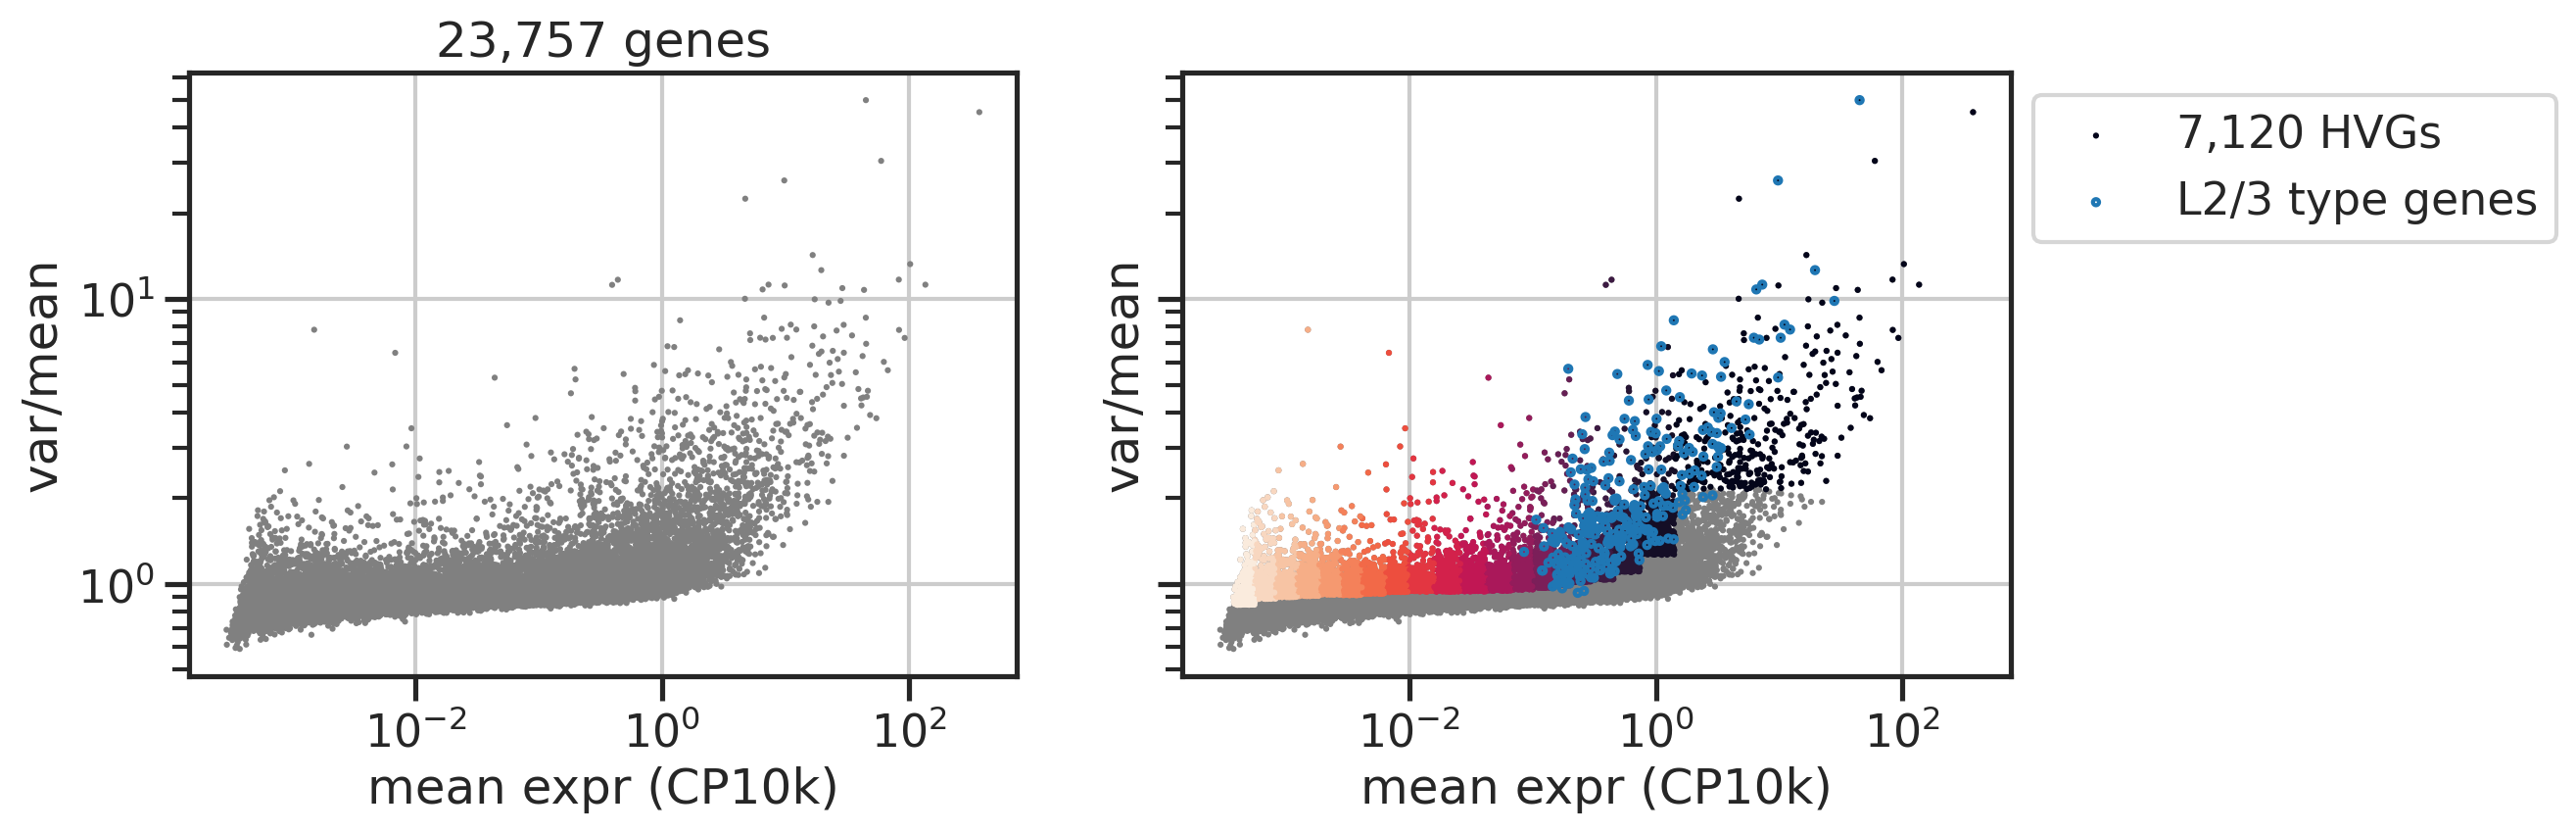

In [13]:
fig, axs = plt.subplots(1,2, figsize=(6*2,4), sharex=True, sharey=True)
ax = axs[0]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
ax.set_title(f'{len(gm):,} genes')

ax = axs[1]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.scatter(gm[gsel_idx], (gv/gm)[gsel_idx], c=lbl[gsel_idx], s=5, edgecolor='none', cmap='rocket_r', label=f'{len(gsel_idx):,} HVGs')
ax.scatter(gm[l23_gidx], (gv/gm)[l23_gidx], s=5, facecolors='none', edgecolor='C0', label='L2/3 type genes')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
ax.legend(bbox_to_anchor=(1,1))

plt.show()

In [14]:
# adata = adata_sub[:,gsel_idx]
adata = adata_sub[:,l23_gidx]
genes_sel = adata.var.index.values
adata

View of AnnData object with n_obs × n_vars = 21269 × 286
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'easitype'
    layers: 'norm', 'lognorm'

In [15]:
adata_nr28 = adata[adata.obs['cond']=='P28NR']
adata_dr28 = adata[adata.obs['cond']=='P28DR']

adata_nr38 = adata[adata.obs['cond']=='P38NR']
adata_dr38 = adata[adata.obs['cond']=='P38DR']

adata_dl28 = adata[adata.obs['cond']=='P28DL']


In [16]:
def pca_pipe(adata):
    
    np.random.seed(0)
    pca = PCA(n_components=4)
    
    zlognorm = zscore(np.array(adata.layers['lognorm'].todense()), axis=0)
    zlognorm = np.nan_to_num(zlognorm, 0)
    
    pcs = pca.fit_transform(zlognorm) # auto centering
    
    return zlognorm-np.mean(zlognorm, axis=0), pca, pcs # manual centering


In [17]:
np.random.seed(0)

X, pca, pcs = pca_pipe(adata)
V = pca.components_.T
V[:,1] = -V[:,1]
pcs[:,1] = -pcs[:,1]


X_nr28, pca_nr28, pcs_nr28 = pca_pipe(adata_nr28)

X_dr28, pca_dr28, pcs_dr28 = pca_pipe(adata_dr28)

X_nr38, pca_nr38, pcs_nr38 = pca_pipe(adata_nr38)
X_dr38, pca_dr38, pcs_dr38 = pca_pipe(adata_dr38)

X_dl28, pca_dl28, pcs_dl28 = pca_pipe(adata_dl28)

# np.all(X_nr28.dot(V_nr28) - pcs_nr28 < 1e-1), (X_nr28.dot(V_nr28) - pcs_nr28).max() #.shape

In [18]:
def organize_pc_res(adata, pcs):
    """
    """
    df = adata.obs.join(pd.DataFrame(pcs, 
                                     index=adata.obs.index, 
                                     columns=np.char.add("PC", (1+np.arange(pcs.shape[1])).astype(str))))
    return df

In [19]:
df_nr28 = organize_pc_res(adata_nr28, X_nr28.dot(V))
df_dr28 = organize_pc_res(adata_dr28, X_dr28.dot(V))

df_nr38 = organize_pc_res(adata_nr38, X_nr38.dot(V))
df_dr38 = organize_pc_res(adata_dr38, X_dr38.dot(V))

df_dl28 = organize_pc_res(adata_dl28, X_dl28.dot(V))

In [20]:
palette_type = collections.OrderedDict({
    "L2/3_A": "C0",
    "L2/3_B": "C1",
    "L2/3_C": "C2",
})
palette_type_list = [c for i, c in palette_type.items()]

In [21]:
dfs = [df_nr28, df_nr38, df_dr28, df_dr38, df_dl28]
labels = ['NR_P28', 'NR_P38', 'DR_P28', 'DR_P38', 'DL_P28']

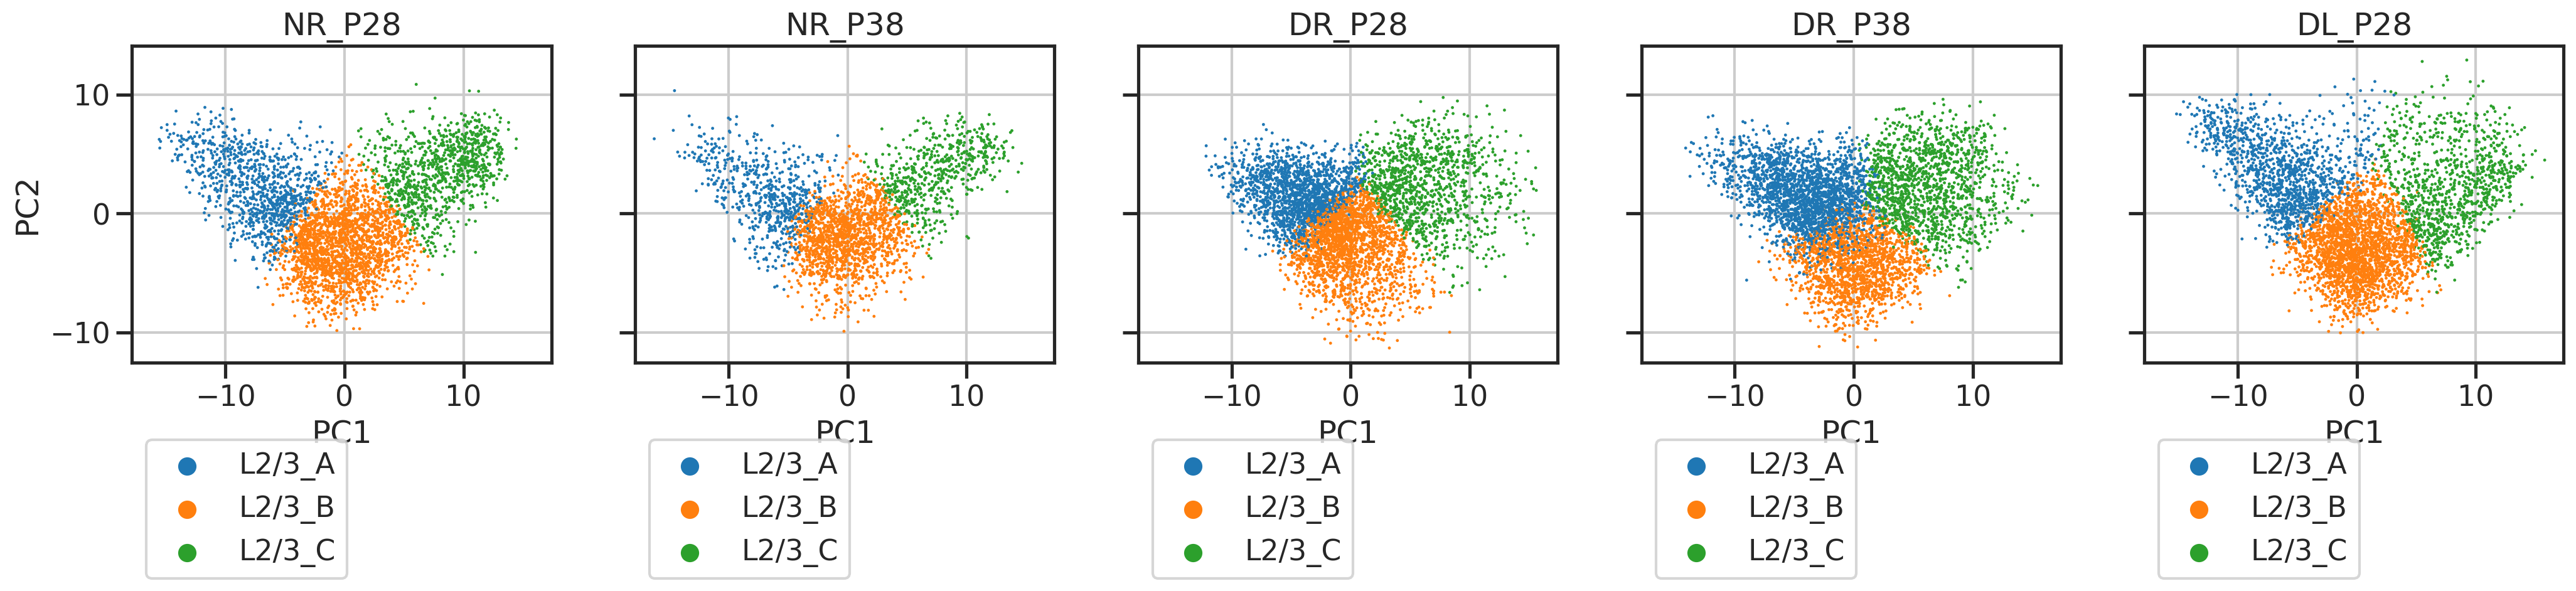

In [22]:
fig, axs = plt.subplots(1, 5, figsize=(5*5,1*4), sharex=True, sharey=True)
for ax, df, lbl in zip(axs, dfs, labels):
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='newtype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), ax=ax)
    ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
    ax.set_title(lbl)
    ax.set_aspect('equal')

plt.show()

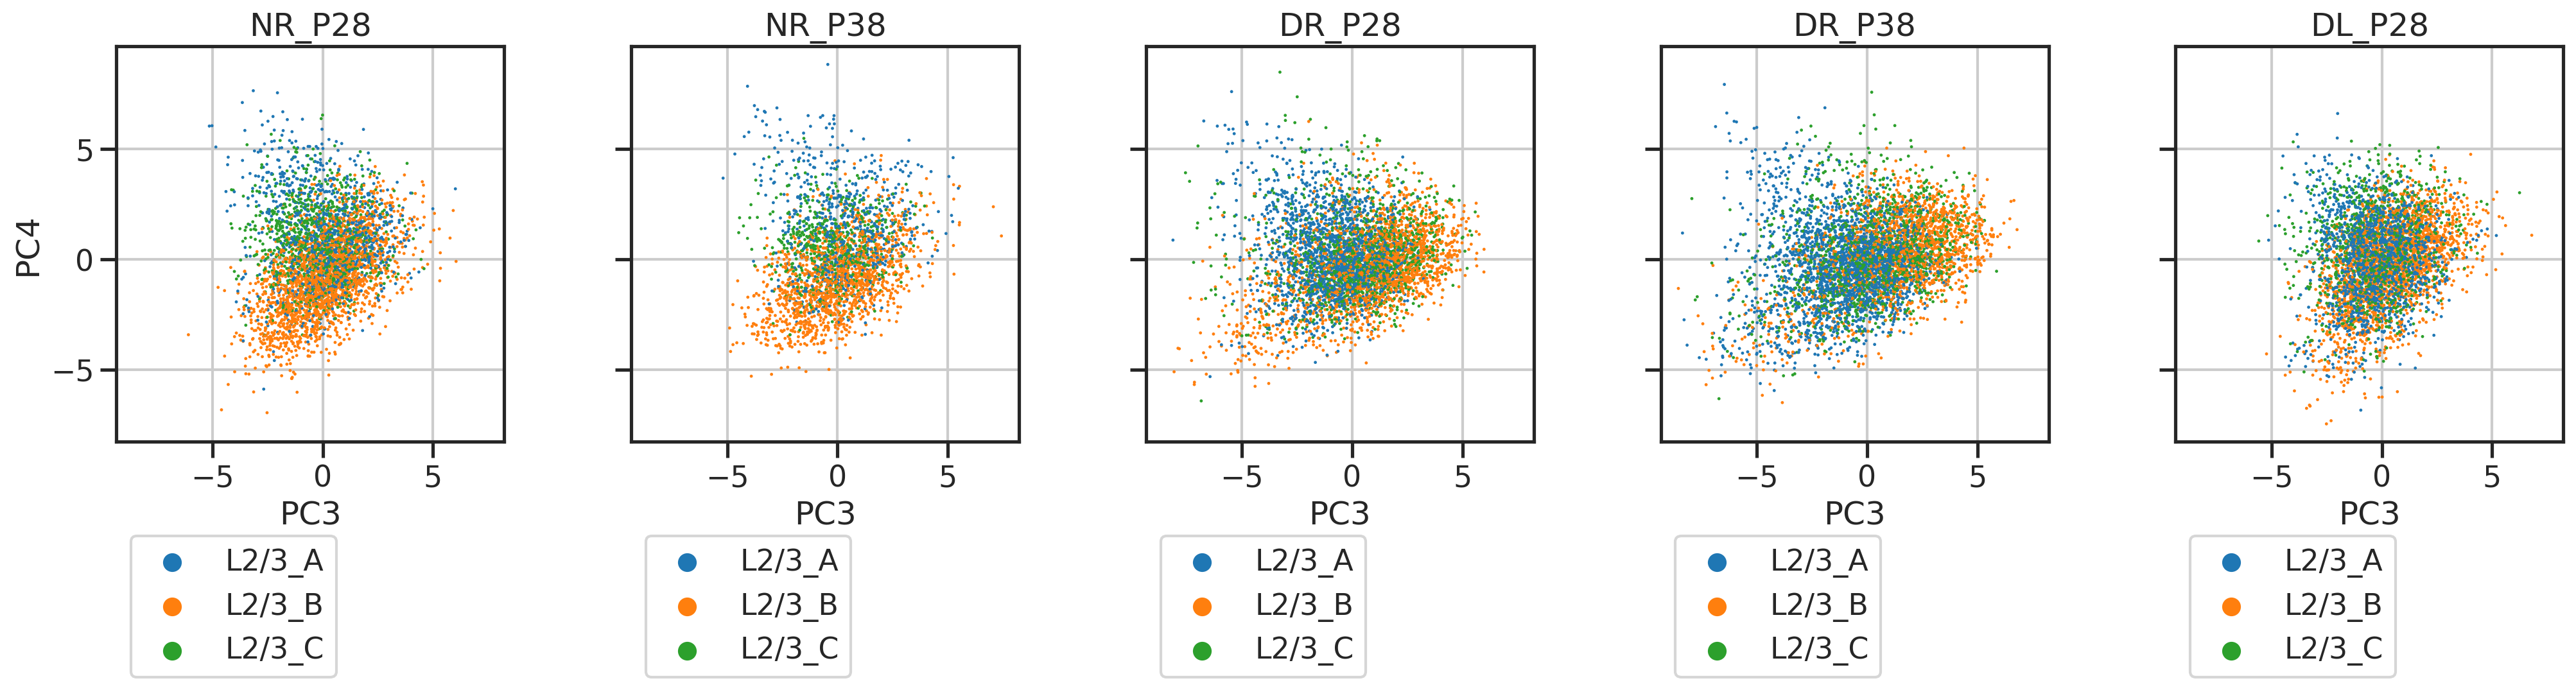

In [23]:
fig, axs = plt.subplots(1, 5, figsize=(5*5,1*4), sharex=True, sharey=True)
for ax, df, lbl in zip(axs, dfs, labels):
    sns.scatterplot(data=df, x='PC3', y='PC4', hue='newtype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), ax=ax)
    ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
    ax.set_title(lbl)
    ax.set_aspect('equal')

plt.show()

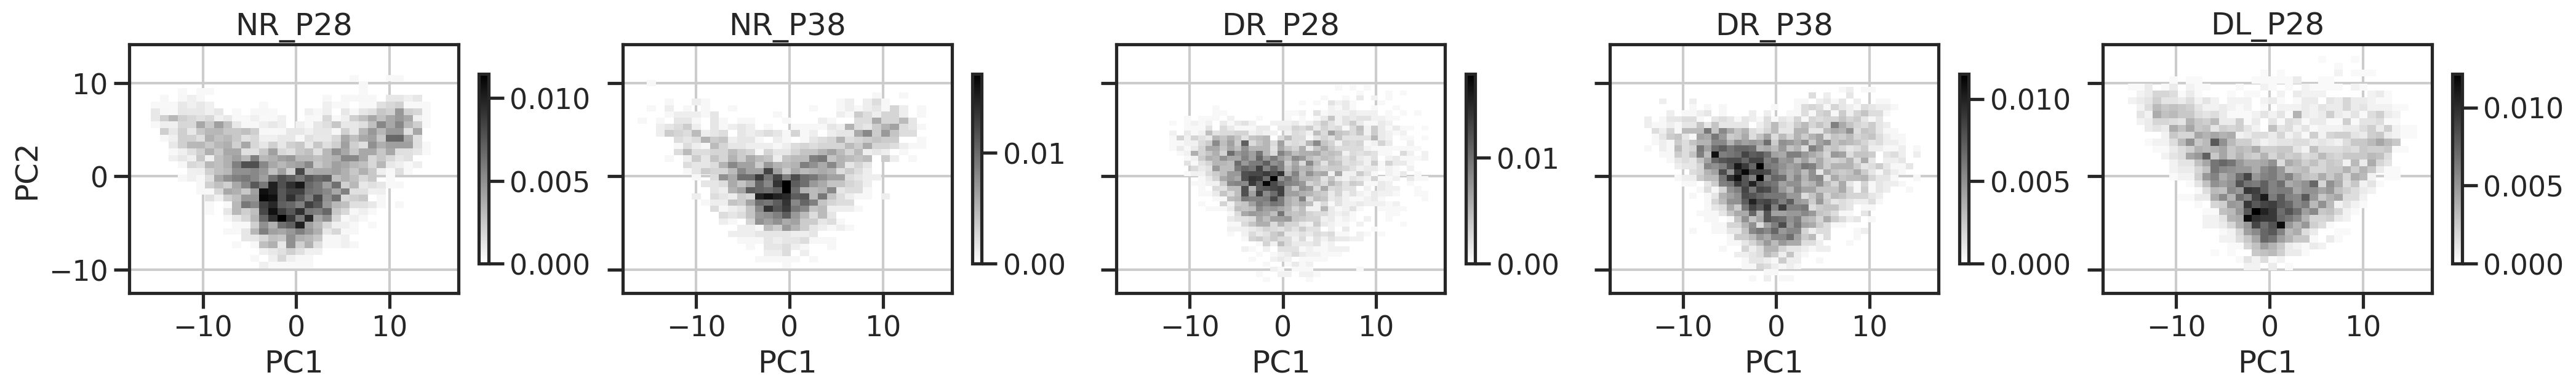

In [24]:
fig, axs = plt.subplots(1, 5, figsize=(5*5,1*4), sharex=True, sharey=True)
for ax, df, lbl in zip(axs, dfs, labels):
    sns.histplot(ax=ax, data=df, stat='density', x='PC1', y='PC2', cmap='gray_r', cbar=True, cbar_kws=dict(shrink=0.5))
    # ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
    ax.set_title(lbl)
    ax.set_aspect('equal')
plt.show()

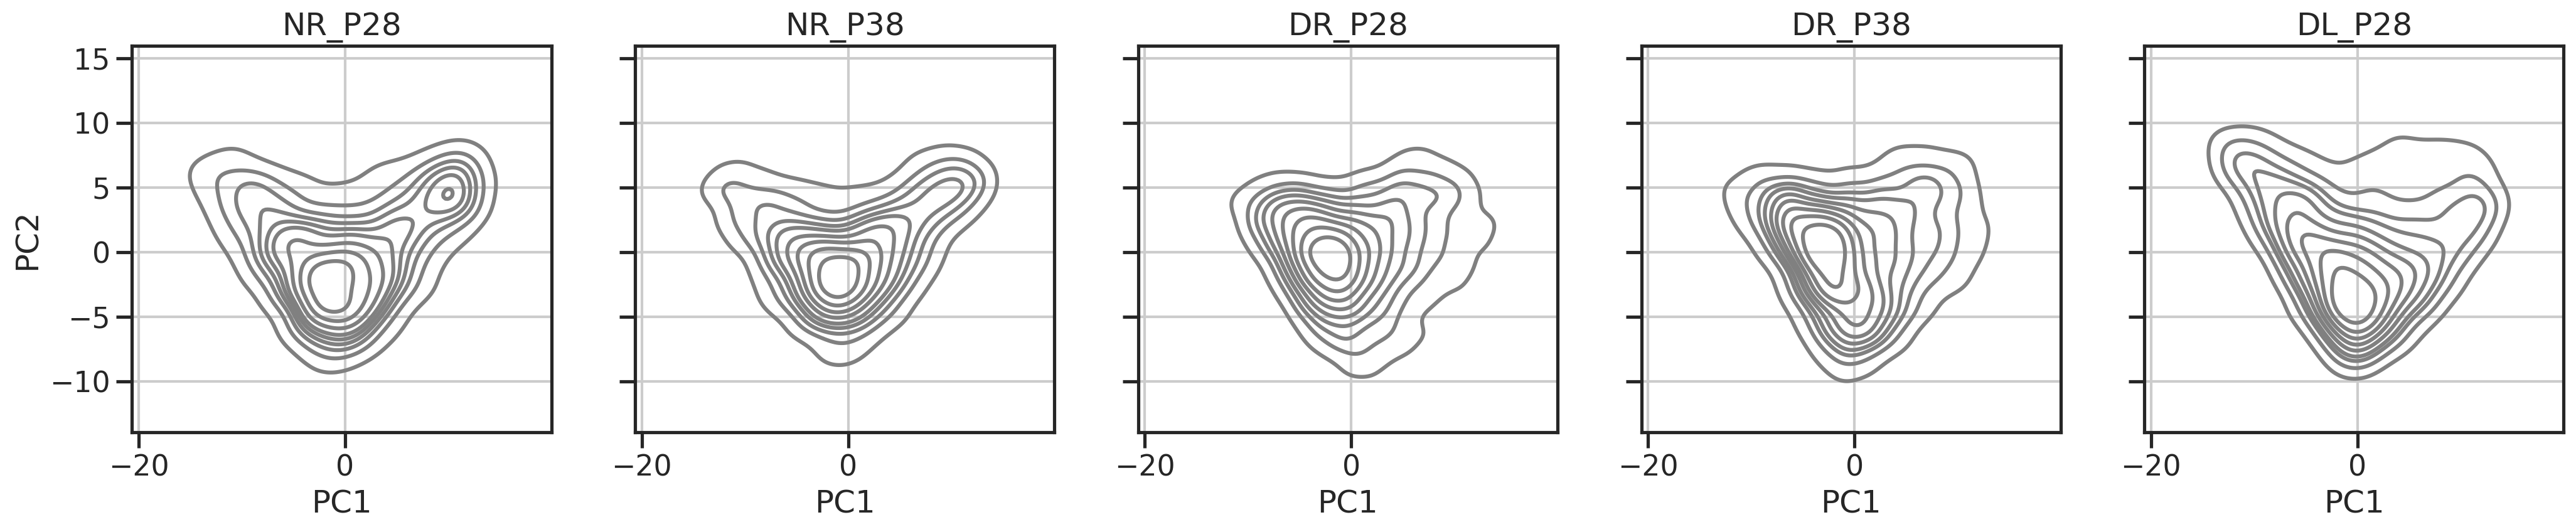

In [25]:
fig, axs = plt.subplots(1, 5, figsize=(5*5,1*4), sharex=True, sharey=True)
for ax, df, lbl in zip(axs, dfs, labels):
    sns.kdeplot(data=df, x='PC1', y='PC2', color='gray', zorder=2, ax=ax)
    ax.set_title(lbl)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


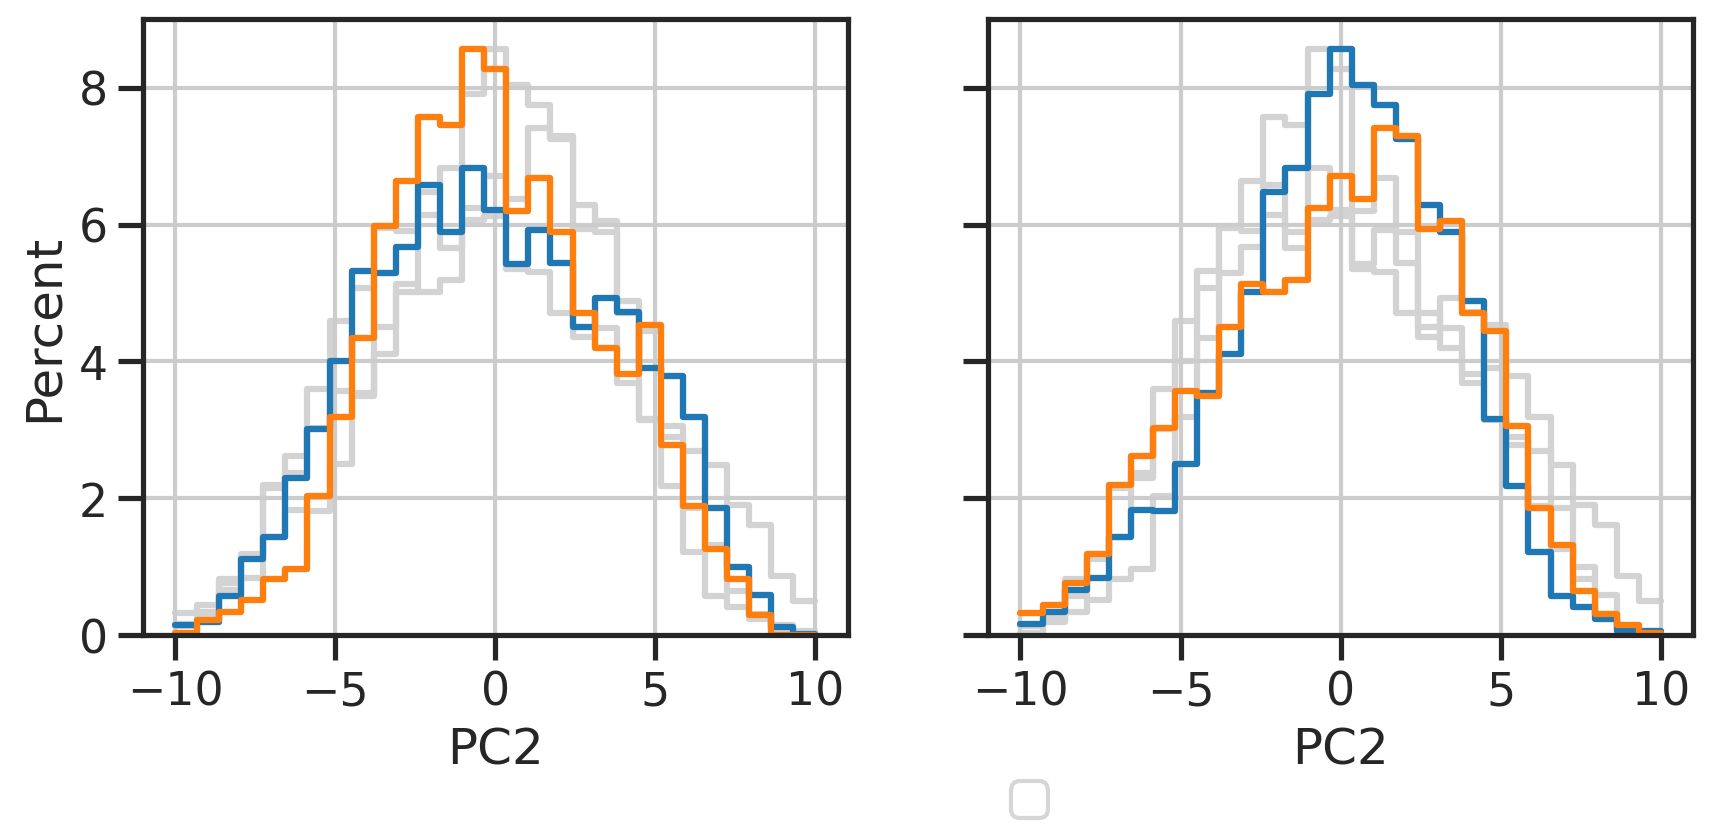

In [26]:
bins = np.linspace(-10, 10, 30) 
fig, axs = plt.subplots(1, 2, figsize=(5*2,1*4), sharex=True, sharey=True)
ax = axs[0]
for df, lbl in zip(dfs, labels):
    sns.histplot(ax=ax, data=df, x='PC2', stat='percent', cumulative=False, bins=bins, 
                 element='step', fill=False, color='lightgray', zorder=0,
                )
    if 'NR' in lbl:
        sns.histplot(ax=ax, data=df, x='PC2', stat='percent', cumulative=False, bins=bins, 
                     element='step', fill=False, 
                    )
        
ax = axs[1]
for df, lbl in zip(dfs, labels):
    sns.histplot(ax=ax, data=df, x='PC2', stat='percent', cumulative=False, bins=bins, 
                 element='step', fill=False, color='lightgray', zorder=0,
                )
    if 'DR' in lbl:
        sns.histplot(ax=ax, data=df, x='PC2', stat='percent', cumulative=False, bins=bins, 
                     element='step', fill=False, 
                    )
        
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
    
plt.show()

# Archetype

In [27]:
from py_pcha import PCHA

In [28]:
np.random.seed(0)
X = pcs[:,:2].T
# X = pcs_nr28[:,:2].T
# X = X_nr28.dot(V)[:,:2].T
XC_raw, S, C, SSE, varexpl = PCHA(X, noc=3, delta=0)
XC_raw = np.array(XC_raw)
print(XC_raw.shape, S.shape, C.shape, SSE.shape, varexpl.shape, SSE, varexpl)

(2, 3) (3, 21269) (21269, 3) () () 2322.9623832324287 0.9975425299926073


In [29]:
# # reorder this
XC = XC_raw.copy()
# tmp = XC[:,2].copy()
# XC[:,2] = XC[:,0]
# XC[:,0] = tmp 
# XC

In [30]:
# dists to A B C 
sa, sb, sc = XC.T

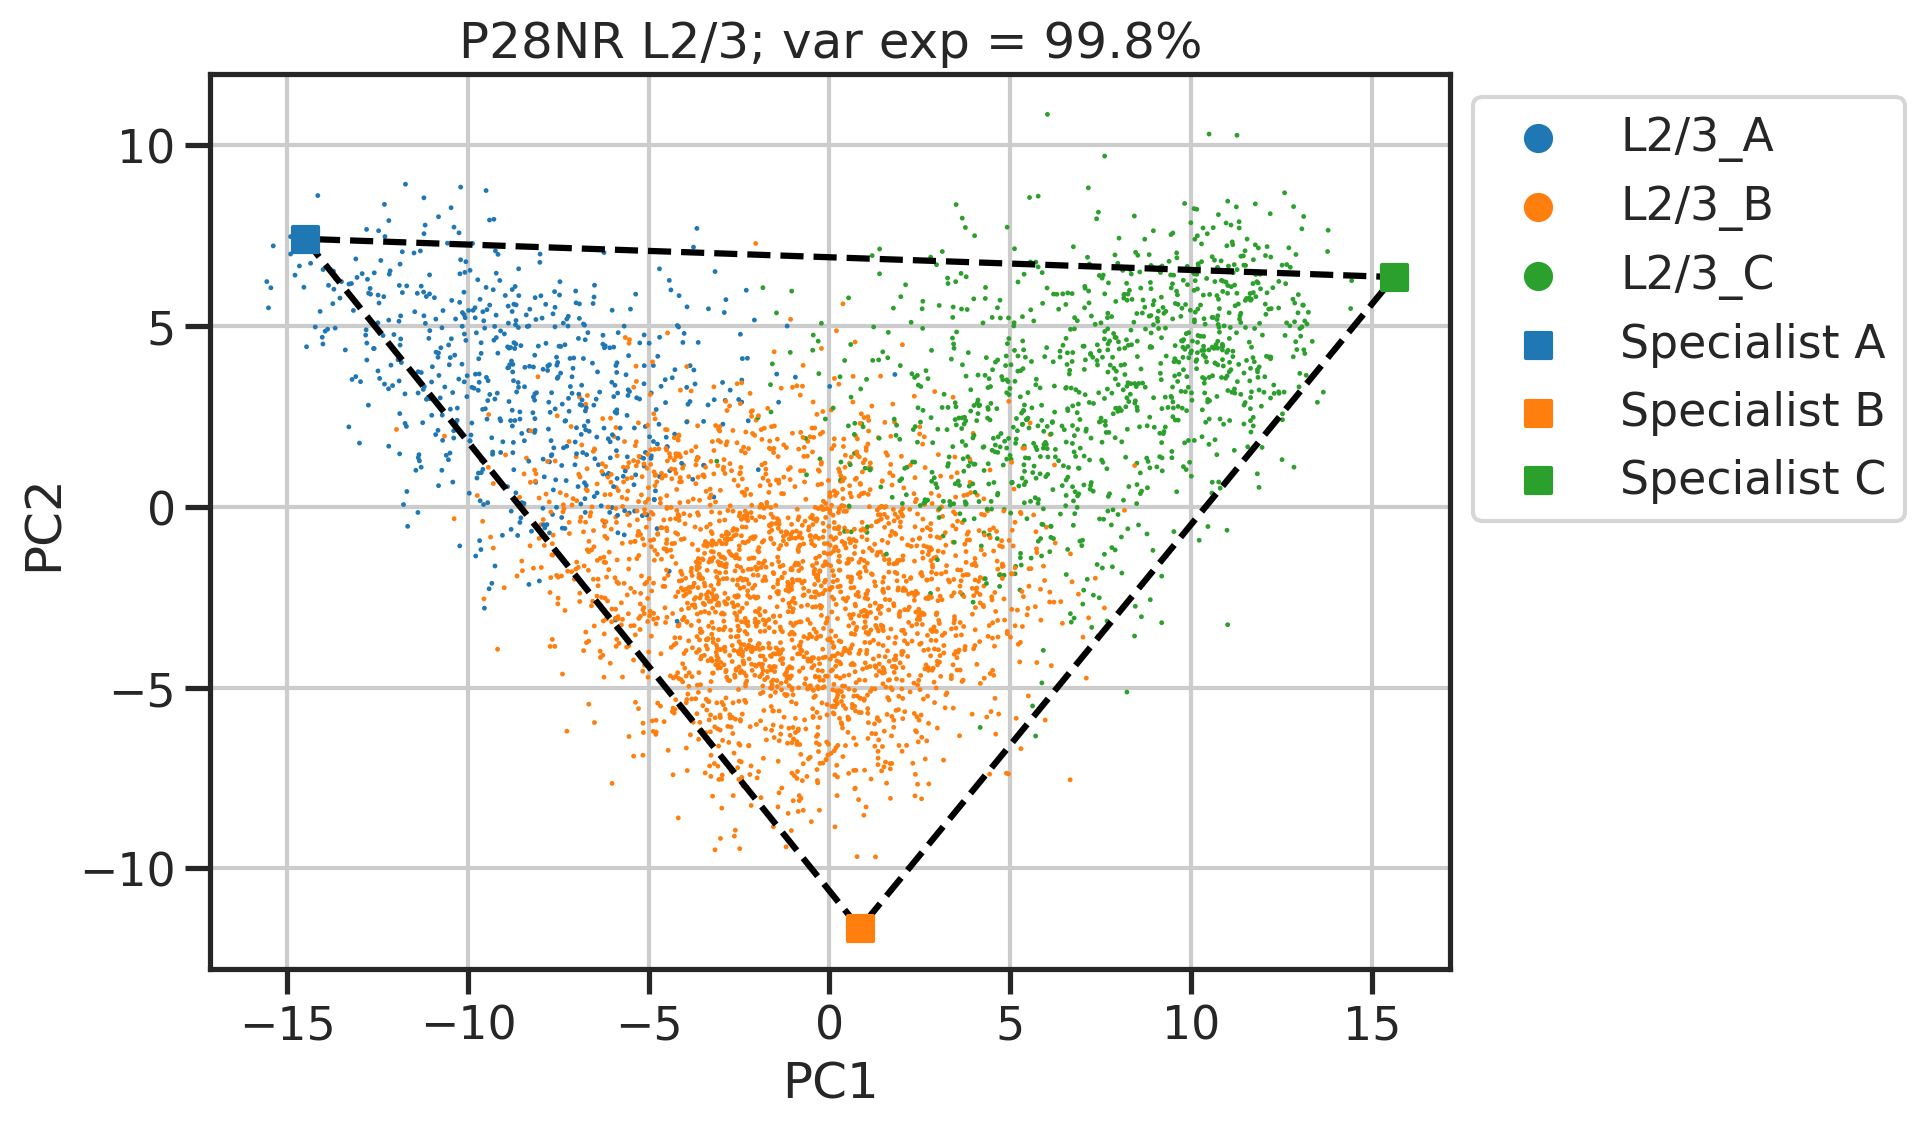

In [31]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=df_nr28, x='PC1', y='PC2', hue='easitype', s=3, palette=palette_type, hue_order=list(palette_type), edgecolor='none', ax=ax)
ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--k', label='', zorder=1)
ax.scatter(XC[0,[0]], XC[1,[0]], color='C0', marker='s', label='Specialist A')
ax.scatter(XC[0,[1]], XC[1,[1]], color='C1', marker='s', label='Specialist B')
ax.scatter(XC[0,[2]], XC[1,[2]], color='C2', marker='s', label='Specialist C')
ax.legend(bbox_to_anchor=(1,1))
ax.set_aspect('equal')
ax.set_title(f'P28NR L2/3; var exp = {100*varexpl:.1f}%')
plt.show()

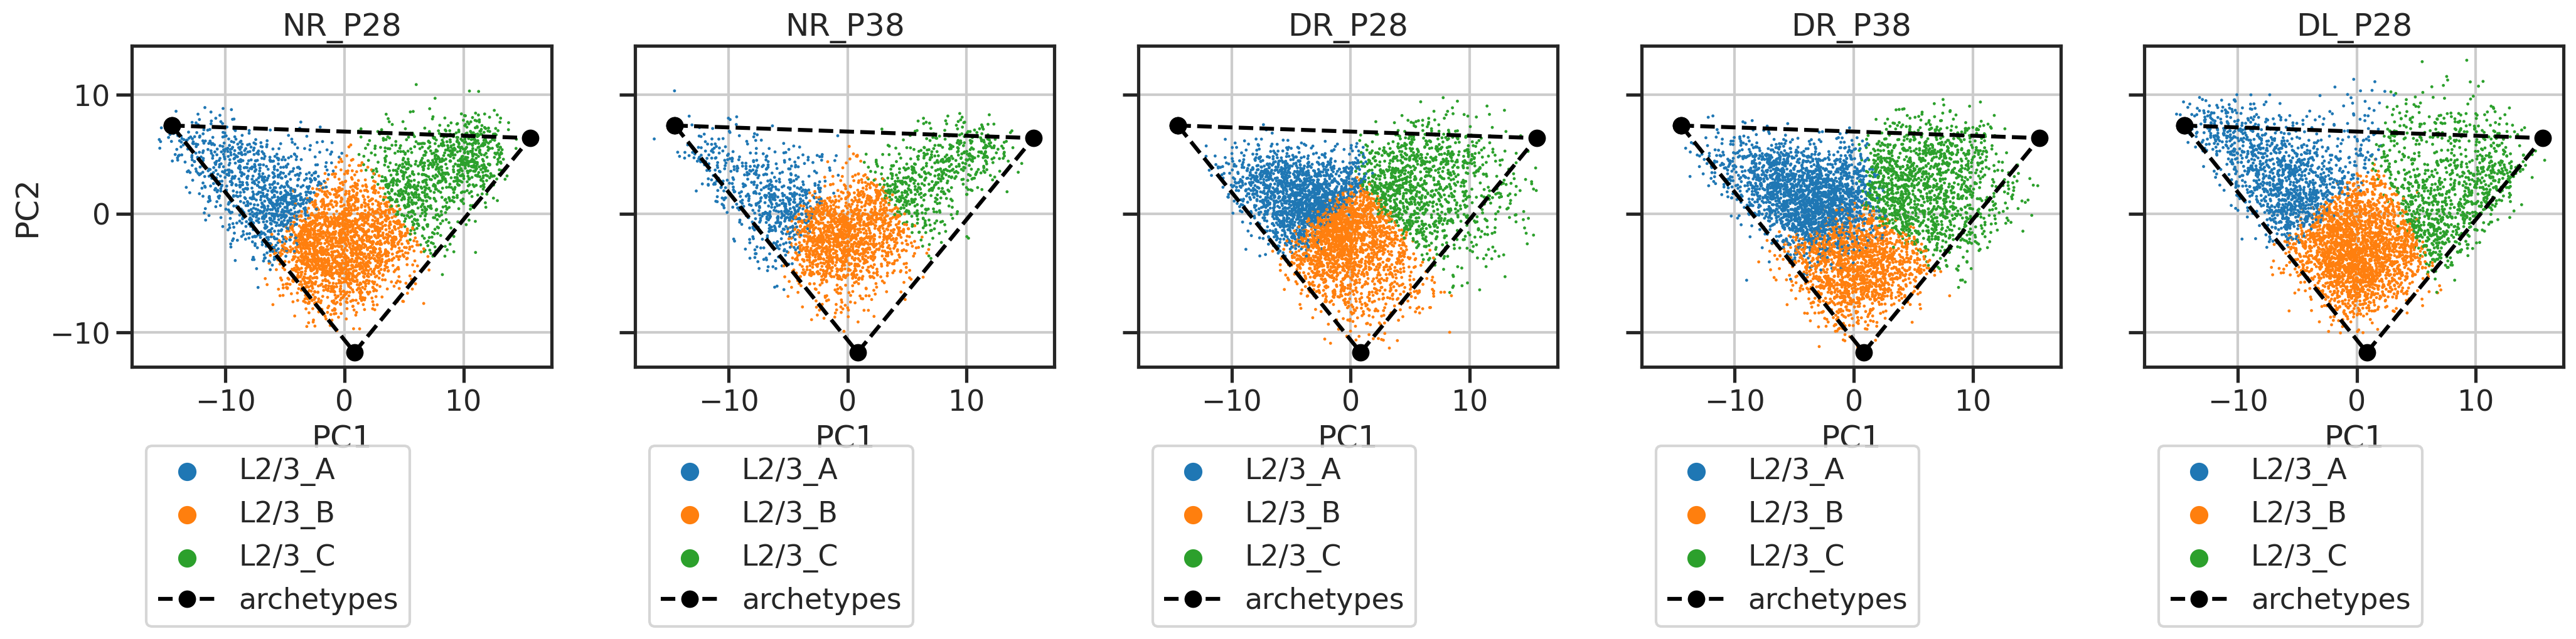

In [32]:

fig, axs = plt.subplots(1, 5, figsize=(5*5,1*4), sharex=True, sharey=True)
for ax, df, lbl in zip(axs, dfs, labels):
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='newtype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), ax=ax)
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--ok', label='archetypes')
    ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
    ax.set_title(lbl)
    ax.set_aspect('equal')

plt.show()

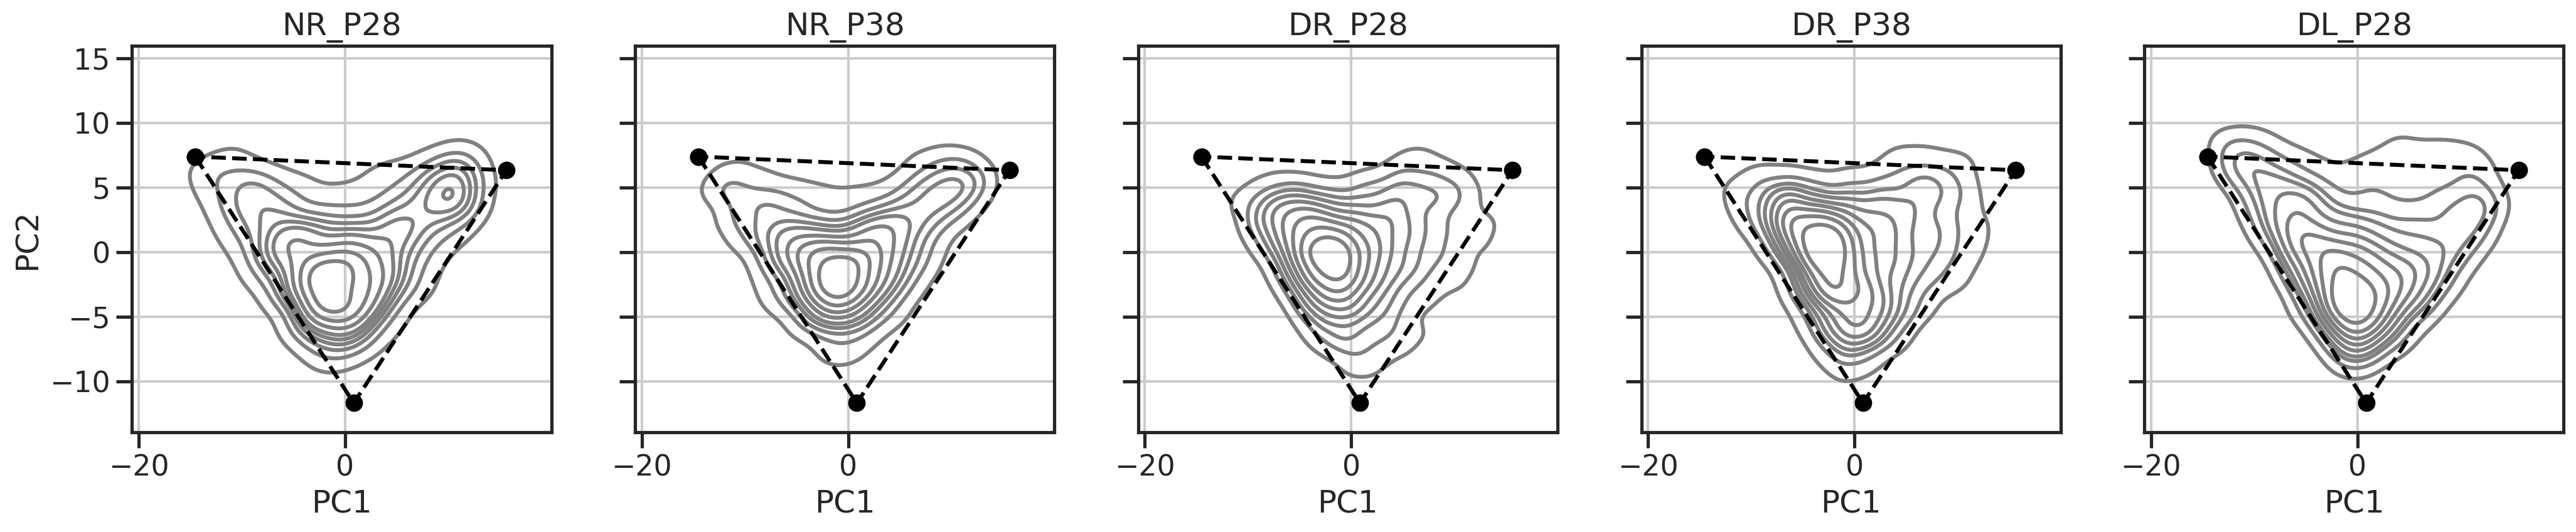

In [33]:
fig, axs = plt.subplots(1, 5, figsize=(5*5,1*4), sharex=True, sharey=True)
for ax, df, lbl in zip(axs, dfs, labels):
    sns.kdeplot(data=df, x='PC1', y='PC2', color='gray', zorder=2, ax=ax)
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--ok', label='archetypes')
    ax.set_title(lbl)
plt.show()

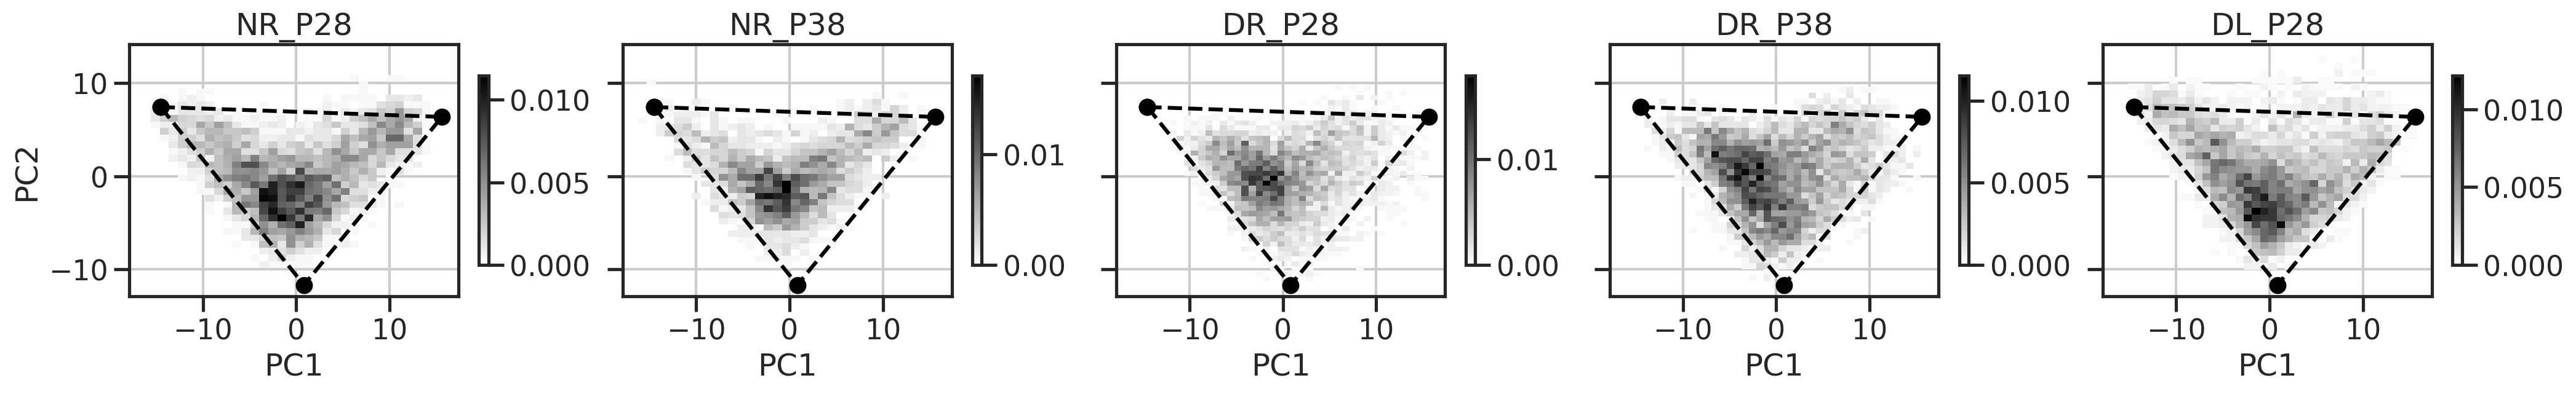

In [34]:
fig, axs = plt.subplots(1, 5, figsize=(5*5,1*4), sharex=True, sharey=True)
for ax, df, lbl in zip(axs, dfs, labels):
    sns.histplot(ax=ax, data=df, stat='density', x='PC1', y='PC2', cmap='gray_r', cbar=True, cbar_kws=dict(shrink=0.5))
    # ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--ok', label='archetypes')
    ax.set_title(lbl)
    ax.set_aspect('equal')
plt.show()

In [35]:
prj_nr28 = df_nr28[['PC1', 'PC2']].values
prj_dr28 = df_dr28[['PC1', 'PC2']].values

prj_nr38 = df_nr38[['PC1', 'PC2']].values
prj_dr38 = df_dr38[['PC1', 'PC2']].values

prj_dl28 = df_dl28[['PC1', 'PC2']].values

In [36]:
adists_nr28 = np.sqrt(np.sum(np.power((prj_nr28 - sa), 2), axis=1))
adists_dr28 = np.sqrt(np.sum(np.power((prj_dr28 - sa), 2), axis=1))

adists_nr38 = np.sqrt(np.sum(np.power((prj_nr38 - sa), 2), axis=1))
adists_dr38 = np.sqrt(np.sum(np.power((prj_dr38 - sa), 2), axis=1))

adists_dl28 = np.sqrt(np.sum(np.power((prj_dl28 - sa), 2), axis=1))

In [37]:
bdists_nr28 = np.sqrt(np.sum(np.power((prj_nr28 - sb), 2), axis=1))
bdists_dr28 = np.sqrt(np.sum(np.power((prj_dr28 - sb), 2), axis=1))

bdists_nr38 = np.sqrt(np.sum(np.power((prj_nr38 - sb), 2), axis=1))
bdists_dr38 = np.sqrt(np.sum(np.power((prj_dr38 - sb), 2), axis=1))

bdists_dl28 = np.sqrt(np.sum(np.power((prj_dl28 - sb), 2), axis=1))

In [38]:
cdists_nr28 = np.sqrt(np.sum(np.power((prj_nr28 - sc), 2), axis=1))
cdists_dr28 = np.sqrt(np.sum(np.power((prj_dr28 - sc), 2), axis=1))

cdists_nr38 = np.sqrt(np.sum(np.power((prj_nr38 - sc), 2), axis=1))
cdists_dr38 = np.sqrt(np.sum(np.power((prj_dr38 - sc), 2), axis=1))

cdists_dl28 = np.sqrt(np.sum(np.power((prj_dl28 - sc), 2), axis=1))

<Axes: ylabel='Percent'>

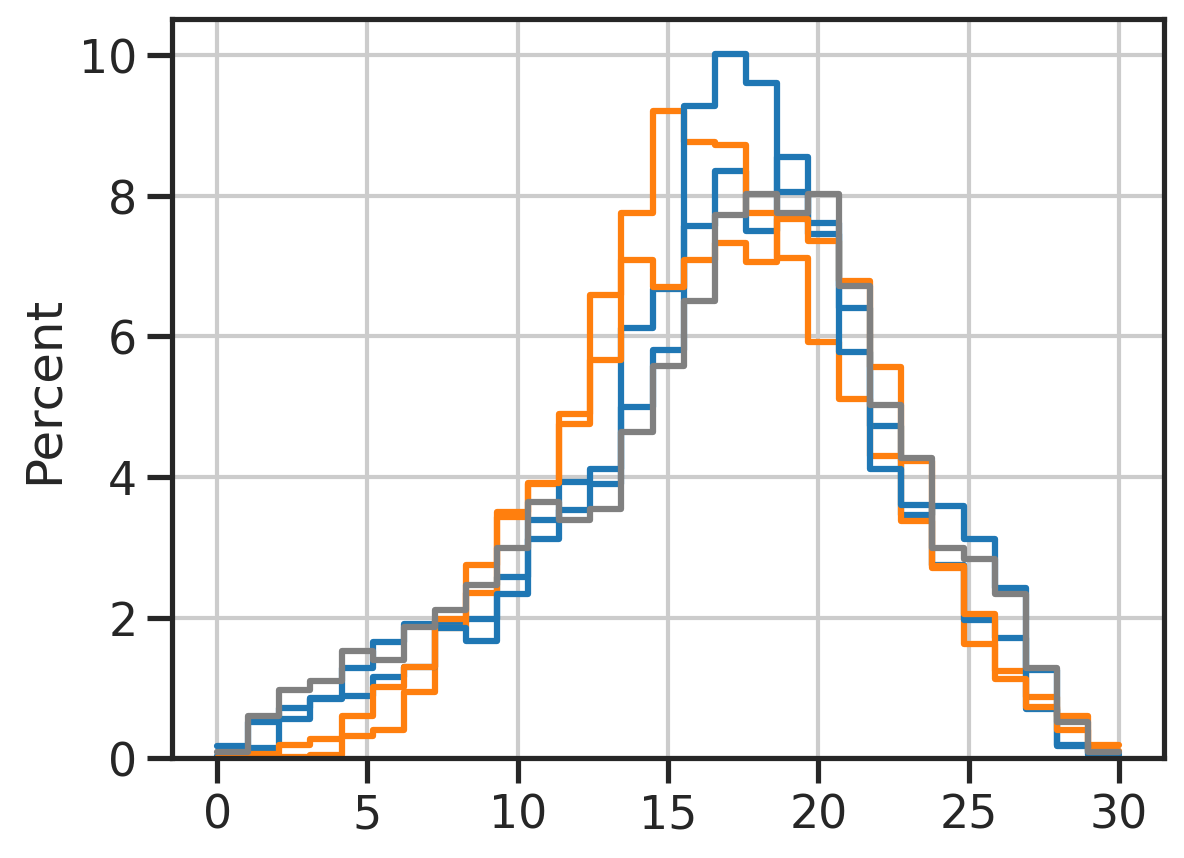

In [39]:
bins = np.linspace(0,30,30)

sns.histplot(adists_nr28, stat='percent', element='step', fill=False, color='C0', bins=bins)
sns.histplot(adists_dr28, stat='percent', element='step', fill=False, color='C1', bins=bins)
sns.histplot(adists_nr38, stat='percent', element='step', fill=False, color='C0', bins=bins)
sns.histplot(adists_dr38, stat='percent', element='step', fill=False, color='C1', bins=bins)
sns.histplot(adists_dl28, stat='percent', element='step', fill=False, color='gray', bins=bins)

<Axes: ylabel='Percent'>

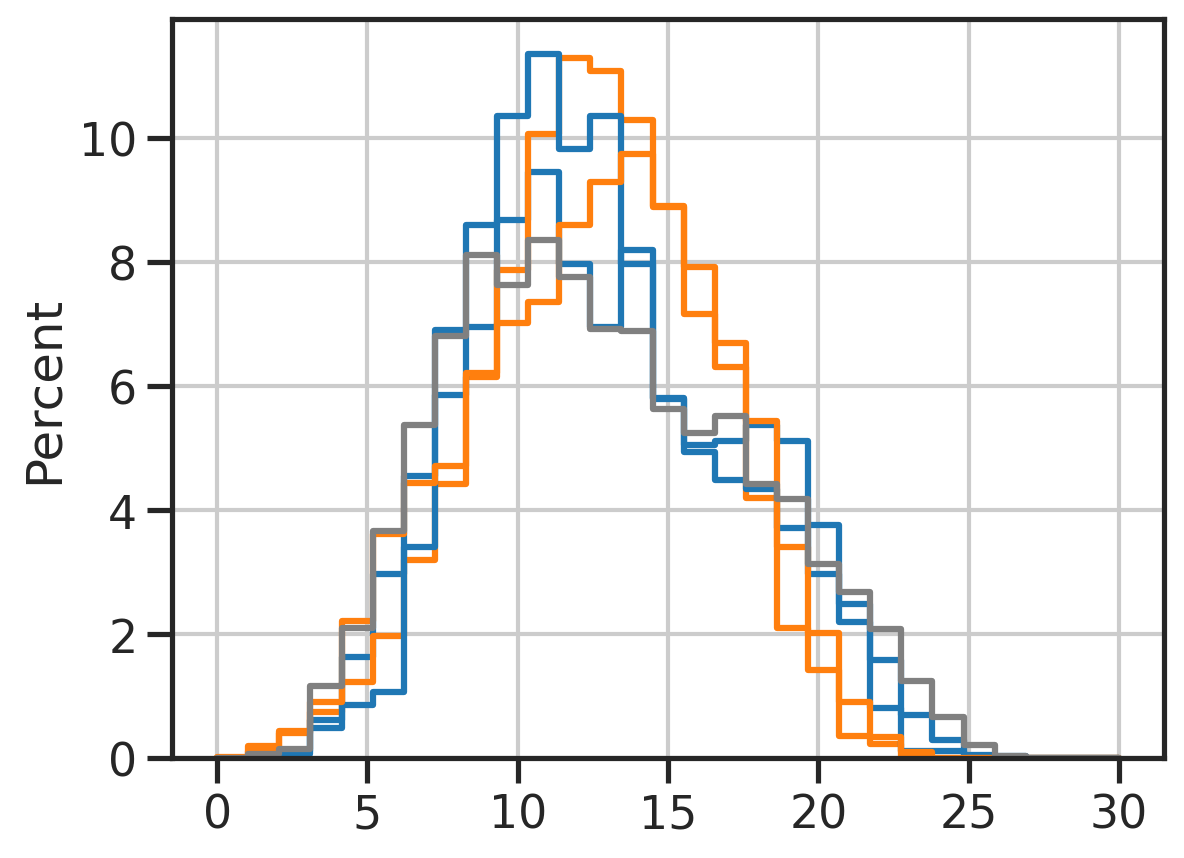

In [40]:
bins = np.linspace(0,30,30)

sns.histplot(bdists_nr28, stat='percent', element='step', fill=False, color='C0', bins=bins)
sns.histplot(bdists_dr28, stat='percent', element='step', fill=False, color='C1', bins=bins)
sns.histplot(bdists_nr38, stat='percent', element='step', fill=False, color='C0', bins=bins)
sns.histplot(bdists_dr38, stat='percent', element='step', fill=False, color='C1', bins=bins)
sns.histplot(bdists_dl28, stat='percent', element='step', fill=False, color='gray', bins=bins)


<Axes: ylabel='Percent'>

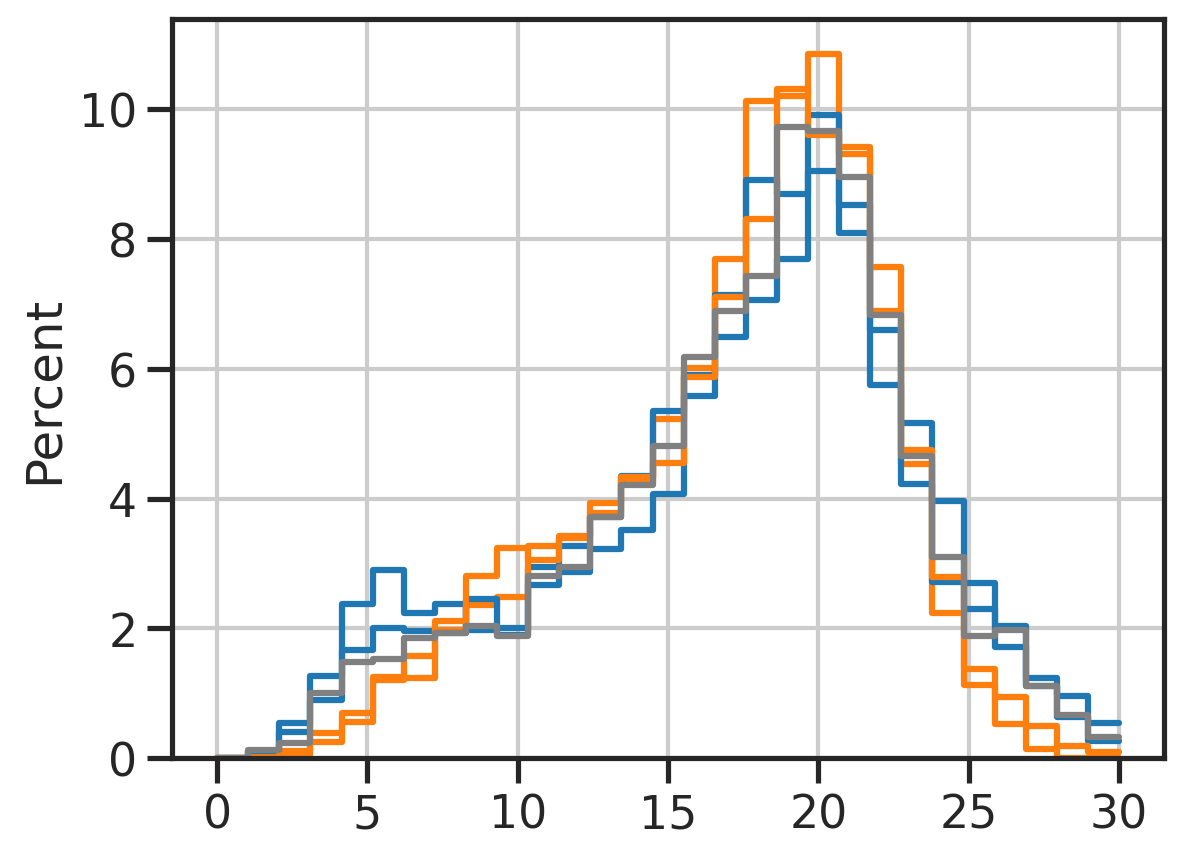

In [41]:
bins = np.linspace(0,30,30)

sns.histplot(cdists_nr28, stat='percent', element='step', fill=False, color='C0', bins=bins)
sns.histplot(cdists_dr28, stat='percent', element='step', fill=False, color='C1', bins=bins)
sns.histplot(cdists_nr38, stat='percent', element='step', fill=False, color='C0', bins=bins)
sns.histplot(cdists_dr38, stat='percent', element='step', fill=False, color='C1', bins=bins)
sns.histplot(cdists_dl28, stat='percent', element='step', fill=False, color='gray', bins=bins)

# closests dist
- tensor
- get the nearest point - which specialist 

In [42]:
dists_nr28 = np.vstack([adists_nr28, bdists_nr28, cdists_nr28])
dists_dr28 = np.vstack([adists_dr28, bdists_dr28, cdists_dr28])

dists_nr28.shape

(3, 4044)

In [43]:
unqs, cnts = np.unique(np.argmin(dists_nr28, axis=0), return_counts=True)
unqs, cnts/cnts.sum()

(array([0, 1, 2]), array([0.22922849, 0.53857567, 0.23219585]))

In [44]:
unqs, cnts = np.unique(np.argmin(dists_dr28, axis=0), return_counts=True)
unqs, cnts/cnts.sum()

(array([0, 1, 2]), array([0.23214286, 0.56568878, 0.20216837]))

# Optimal Transport

In [45]:
import ot
import ot.plot
from matplotlib import collections  as mc

In [46]:
xs = X_nr28.dot(V)[:,:2]
xt = X_dr28.dot(V)[:,:2]
ns = len(xs)
nt = len(xt)
a = np.ones((ns,))/ns
b = np.ones((nt,))/nt

xs.shape, xt.shape

((4044, 2), (4704, 2))

In [47]:
%%time
M = ot.dist(xs, xt)

CPU times: user 819 ms, sys: 1.1 s, total: 1.92 s
Wall time: 154 ms


In [48]:
%%time
G0 = ot.emd(a, b, M)
# Gweak = ot.weak_optimal_transport(xs, xt, a, b)

CPU times: user 4.16 s, sys: 233 ms, total: 4.39 s
Wall time: 4.4 s


/u/home/f/f7xiesnm/.conda/envs/napari/lib/python3.9/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


In [49]:
G0s = sparse.coo_matrix(G0)
i, j, v = G0s.row, G0s.col, G0s.data
i, j, v.shape

(array([   0,    0,    1, ..., 4042, 4043, 4043], dtype=int32),
 array([1692, 3894,   89, ..., 4278, 3983, 4497], dtype=int32),
 (8747,))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'OT matrix with samples')

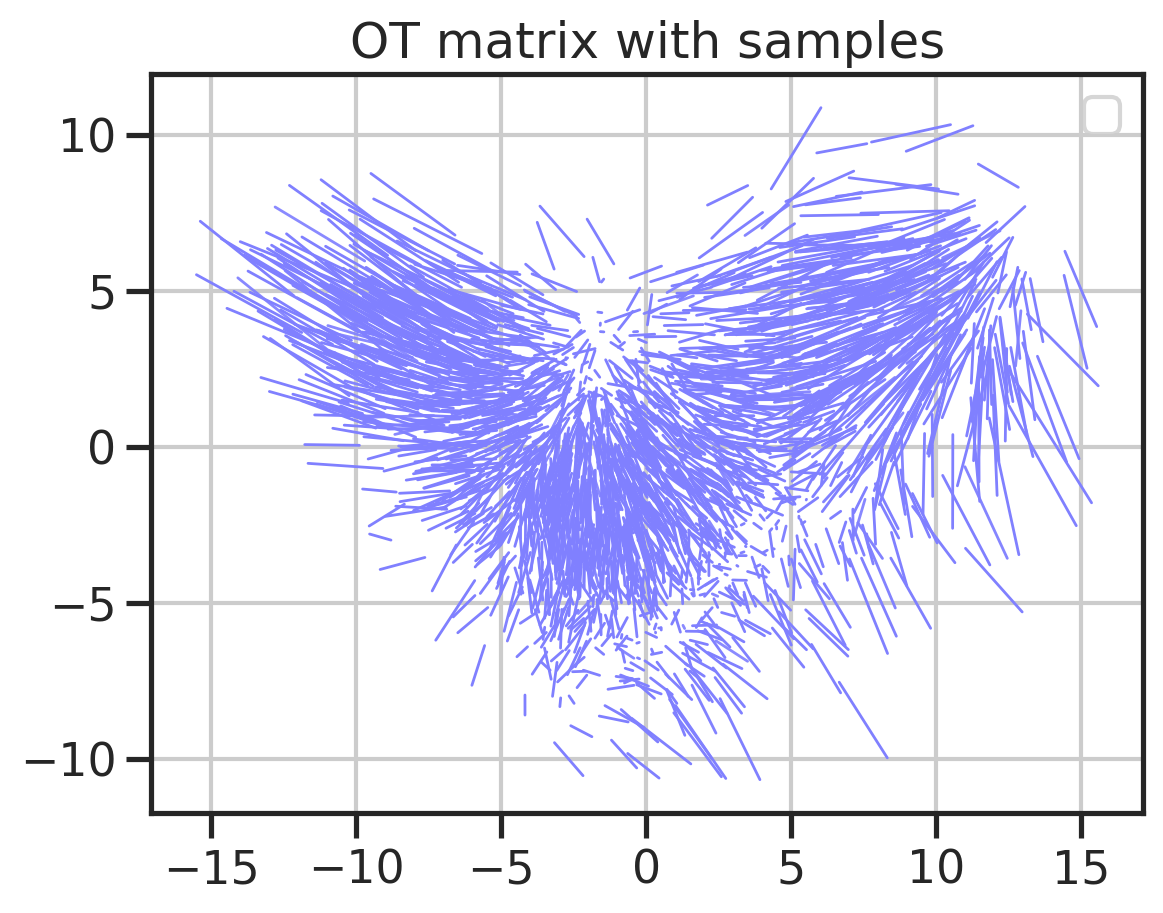

In [50]:
plt.figure(4)
ot.plot.plot2D_samples_mat(xs, xt, G0, c=[.5, .5, 1], thr=0.9, linewidth=1)
plt.legend(loc=0)
plt.title('OT matrix with samples')

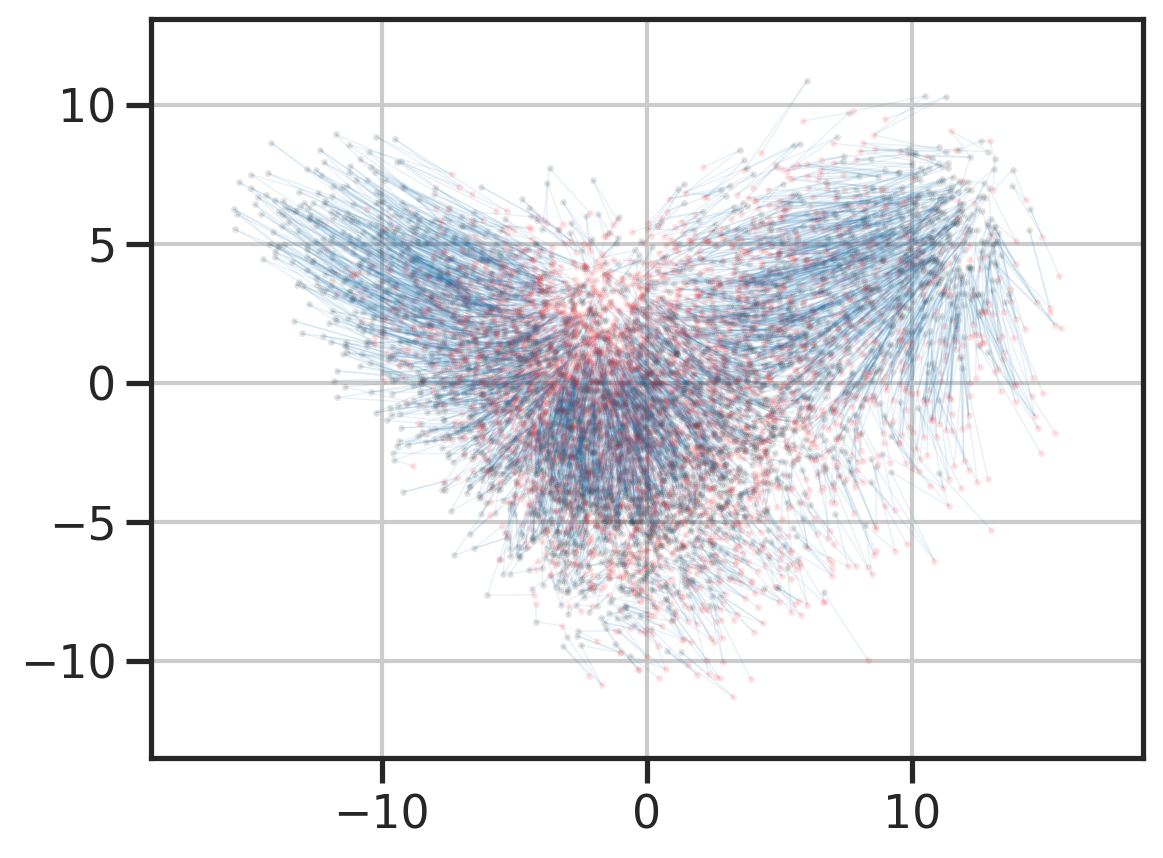

In [51]:
lines = [[xs[i], xt[j]] for i, j in zip(G0s.row, G0s.col)]
# c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])

lc = mc.LineCollection(lines, linewidths=0.5, alpha=0.1)
fig, ax = plt.subplots()
ax.scatter(xs[:,0], xs[:,1], s=1, color='black', alpha=0.1)
ax.add_collection(lc)
ax.scatter(xt[:,0], xt[:,1], s=1, color='red', alpha=0.1)
ax.autoscale()
ax.margins(0.1)

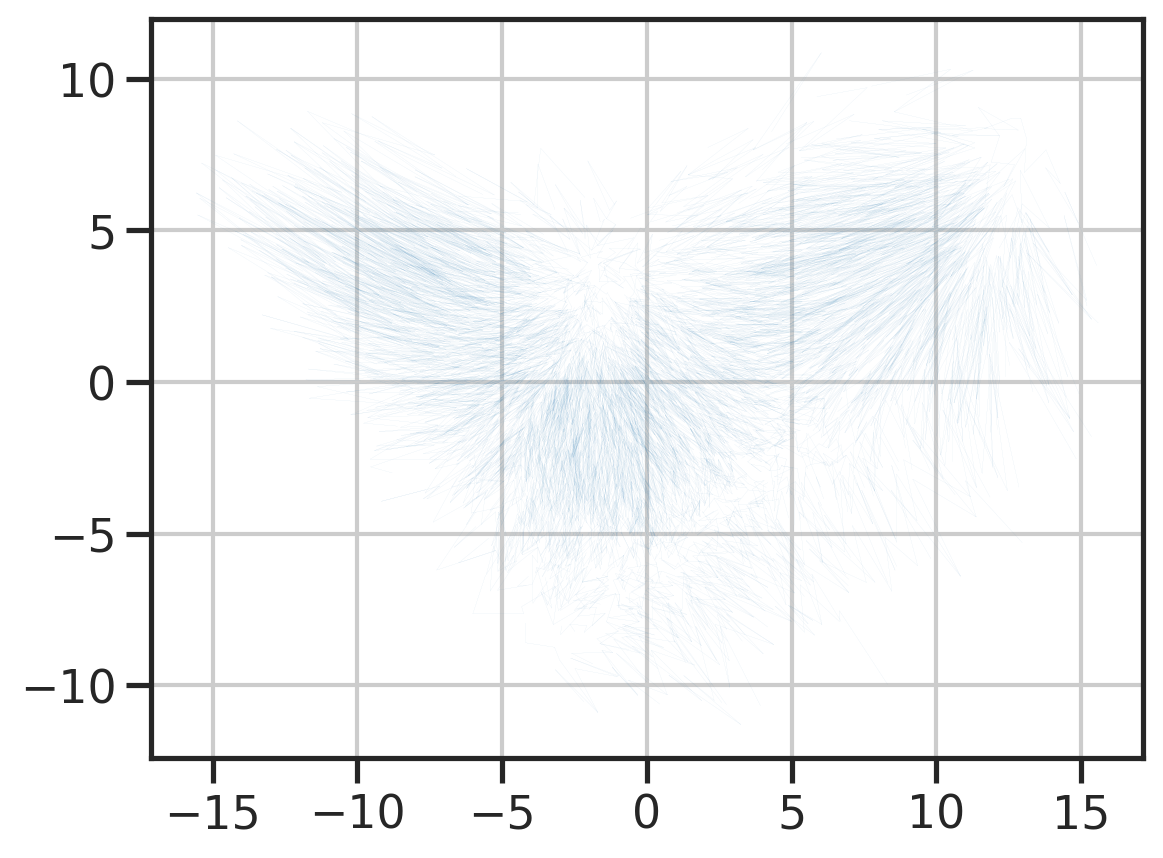

In [52]:
arrows = [np.hstack([xs[i], xt[j]-xs[i]]) for i, j in zip(G0s.row, G0s.col)]
for arrow in arrows:
    plt.arrow(*arrow, edgecolor='none', linewidth=0.2)

# mean field
- i, j

In [53]:
arrows = pd.DataFrame(np.array([np.hstack([xs[i], xt[j]-xs[i]]) for i, j in zip(G0s.row, G0s.col)]))
arrows['xbin'] = pd.cut(arrows[0], 20)
arrows['ybin'] = pd.cut(arrows[1], 20)
arrows


0         1         2         3              xbin  \
0     0.529296  5.783413 -0.498615 -0.274032   (-0.559, 0.941]   
1     0.529296  5.783413 -1.086149 -0.381560   (-0.559, 0.941]   
2     0.342725 -6.012793 -0.417586 -0.036963   (-0.559, 0.941]   
3     0.342725 -6.012793 -0.231268  0.444909   (-0.559, 0.941]   
4     3.446338  4.388937 -2.169167 -0.027398    (2.442, 3.942]   
...        ...       ...       ...       ...               ...   
8742  1.728222 -0.679115 -0.634376  0.493097    (0.941, 2.442]   
8743  0.115831 -0.901231 -0.844858  0.993377   (-0.559, 0.941]   
8744  0.115831 -0.901231 -0.870948  0.892666   (-0.559, 0.941]   
8745 -3.963285 -4.678137  0.354333  0.770435  (-5.061, -3.561]   
8746 -3.963285 -4.678137 -0.229544  1.008536  (-5.061, -3.561]   

                  ybin  
0       (5.686, 6.721]  
1       (5.686, 6.721]  
2     (-6.729, -5.694]  
3     (-6.729, -5.694]  
4       (3.617, 4.652]  
...                ...  
8742  (-1.556, -0.521]  
8743  (-1.556, -0.521]  
8744  (-1.556, -0.521]  
8745   (-5.694, -4.66]  
8746   (-5.694, -4.66]  

[8747 rows x 6 columns]

In [54]:
n_arrows = arrows.groupby(['xbin', 'ybin']).size()
n_arrows = n_arrows[n_arrows!=0] # .dropna()
n_arrows

xbin                ybin          
(-15.596, -14.065]  (3.617, 4.652]     2
                    (4.652, 5.686]     6
                    (5.686, 6.721]    11
                    (6.721, 7.756]    10
                    (7.756, 8.79]      2
                                      ..
(12.946, 14.447]    (3.617, 4.652]    10
                    (4.652, 5.686]    21
                    (5.686, 6.721]     4
                    (6.721, 7.756]     6
                    (7.756, 8.79]      2
Length: 258, dtype: int64

<Axes: ylabel='Count'>

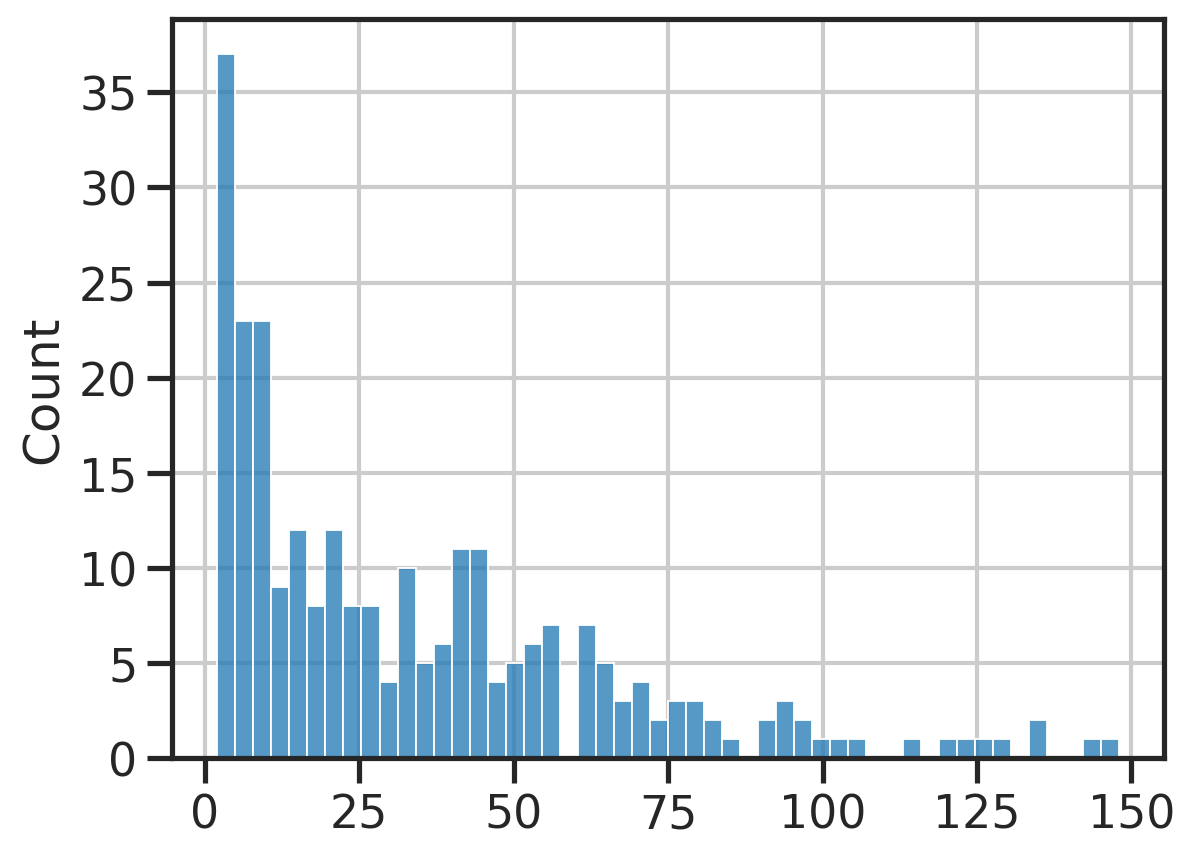

In [55]:
sns.histplot(n_arrows, bins=50)

In [56]:
mean_arrows = arrows.groupby(['xbin', 'ybin']).mean().dropna()
# mean_arrows = mean_arrows[n_arrows > 10]
mean_arrows

0         1         2         3
xbin               ybin                                                   
(-15.596, -14.065] (3.617, 4.652] -14.466850  4.430477  3.741066 -1.821025
                   (4.652, 5.686] -14.612202  5.297428  3.411053 -1.759302
                   (5.686, 6.721] -15.052988  6.284688  3.660751 -2.371662
                   (6.721, 7.756] -14.766681  7.191655  3.667736 -2.118952
                   (7.756, 8.79]  -14.154671  8.613982  4.383173 -3.045332
...                                      ...       ...       ...       ...
(12.946, 14.447]   (3.617, 4.652]  13.166708  4.101242  1.235973 -2.481010
                   (4.652, 5.686]  13.225769  5.241803  0.669951 -2.324585
                   (5.686, 6.721]  13.709282  6.066063  0.523450 -1.501625
                   (6.721, 7.756]  13.548999  7.470254 -0.115616 -1.095862
                   (7.756, 8.79]   13.120392  8.034698 -0.133068 -0.230960

[258 rows x 4 columns]

/tmp/ipykernel_1547/1538066926.py:2: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.arrow(*arrow, edgecolor='none', linewidth=0.1, width=0.1, color='k')


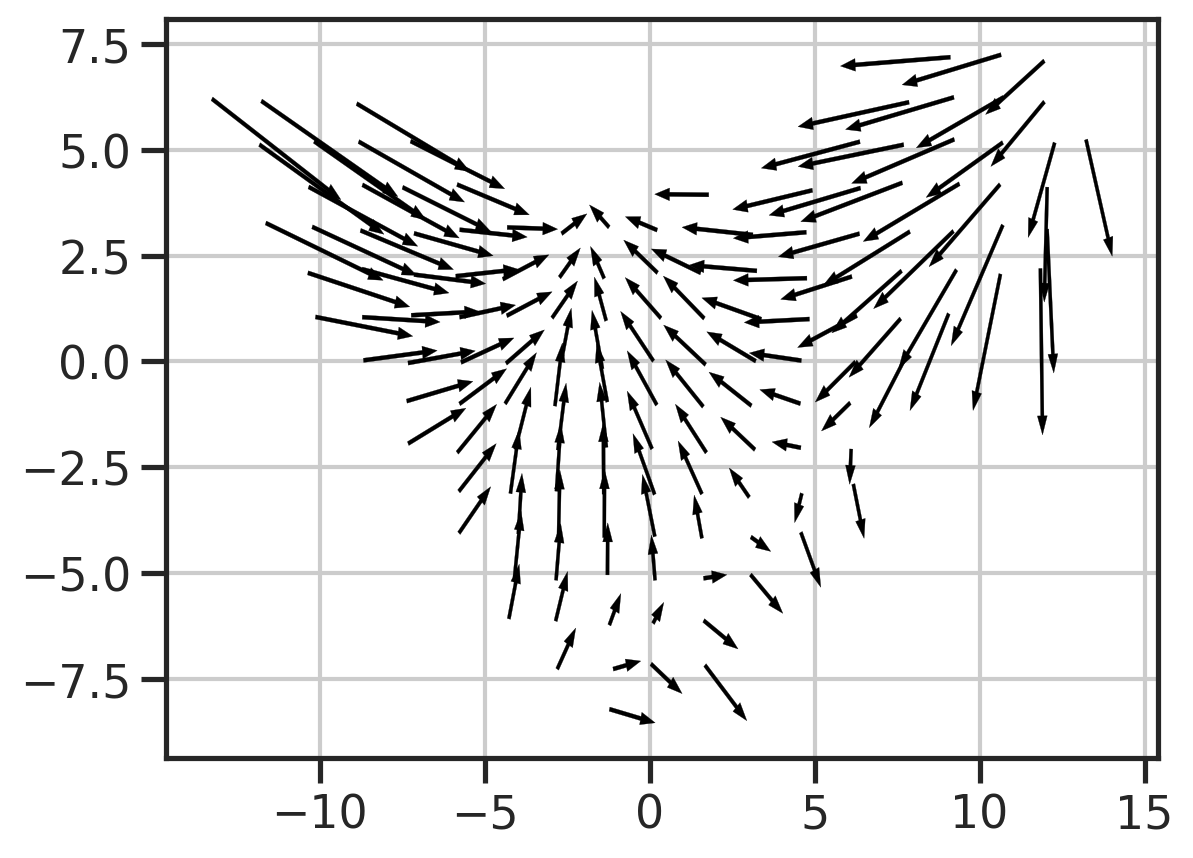

In [57]:
for idx, arrow in mean_arrows[n_arrows > 20].iterrows():
    plt.arrow(*arrow, edgecolor='none', linewidth=0.1, width=0.1, color='k')
# for idx, arrow in mean_arrows[n_arrows <= 20].iterrows():
#     plt.arrow(*arrow, edgecolor='none', linewidth=0.1, width=0.1, color='gray')

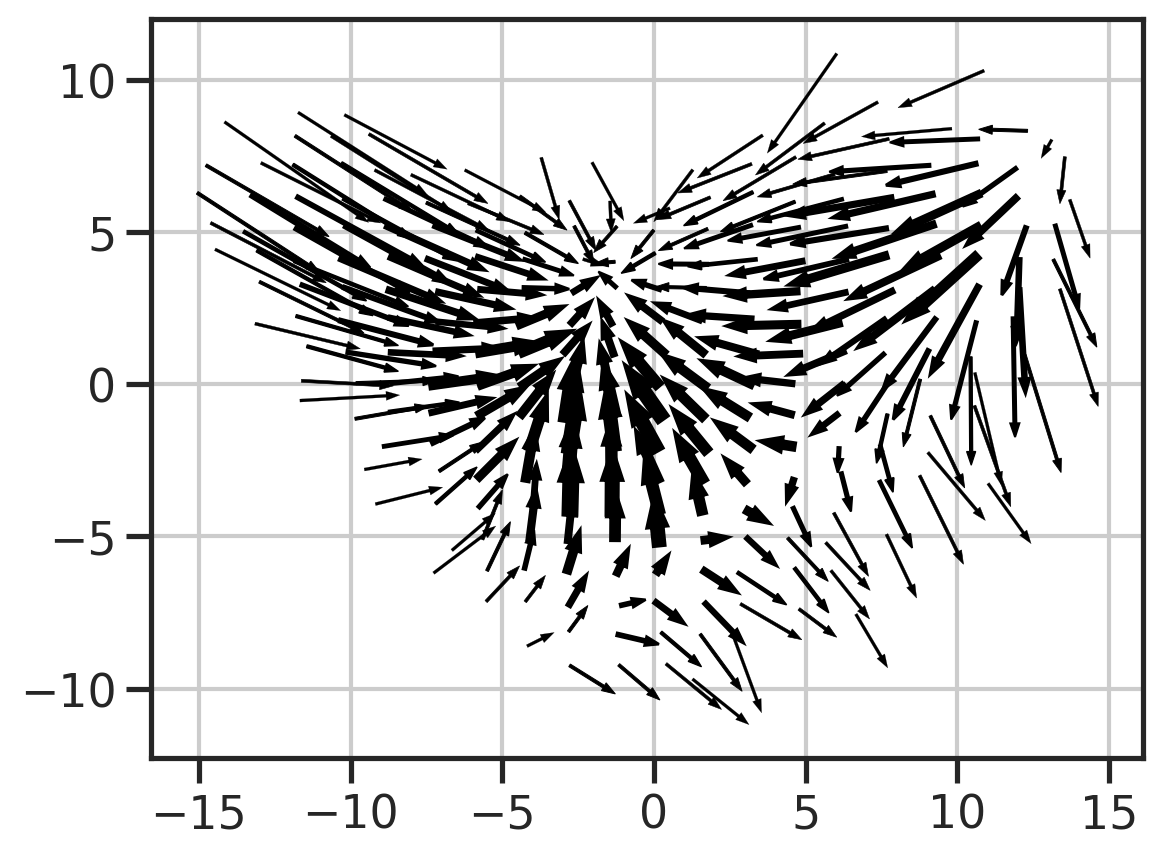

In [58]:
maxsize = np.max(n_arrows)
for size, arrow in zip(n_arrows.values, mean_arrows.values):
    plt.arrow(*arrow, linewidth=5*size/maxsize, width=0.1, color='k')

In [59]:
n_arrows.min()/maxsize

0.013513513513513514

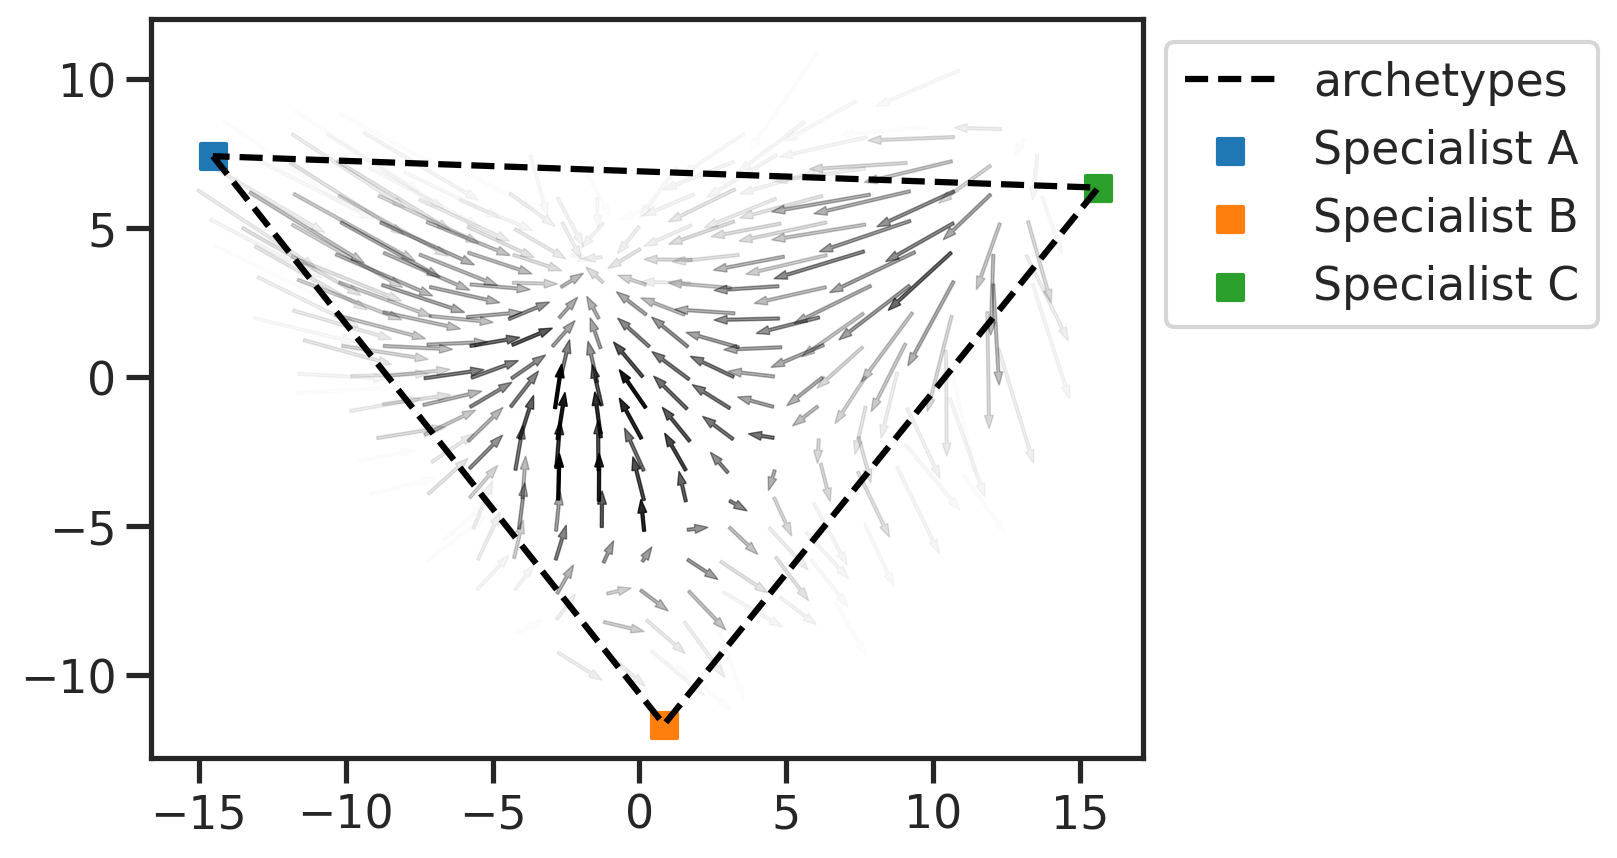

In [60]:
maxsize = np.max(n_arrows)
fig, ax = plt.subplots()
for size, arrow in zip(n_arrows.values, mean_arrows.values):
    ax.arrow(*arrow, linewidth=0.5, width=0.1, color='k', alpha=size/maxsize)
    
ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--k', label='archetypes')
ax.scatter(XC[0,[0]], XC[1,[0]], color='C0', marker='s', label='Specialist A')
ax.scatter(XC[0,[1]], XC[1,[1]], color='C1', marker='s', label='Specialist B')
ax.scatter(XC[0,[2]], XC[1,[2]], color='C2', marker='s', label='Specialist C')
ax.grid(False)
ax.legend(bbox_to_anchor=(1,1))


# control - sample 1 vs sample 2 
# add connection strength? 

# quantify distance to closest specialist

In [61]:
dists_nr28 = np.vstack([adists_nr28, bdists_nr28, cdists_nr28])
dists_nr38 = np.vstack([adists_nr38, bdists_nr38, cdists_nr38])

dists_dr28 = np.vstack([adists_dr28, bdists_dr28, cdists_dr28])
dists_dr38 = np.vstack([adists_dr38, bdists_dr38, cdists_dr38])

dists_dl28 = np.vstack([adists_dl28, bdists_dl28, cdists_dl28])

<Axes: ylabel='Percent'>

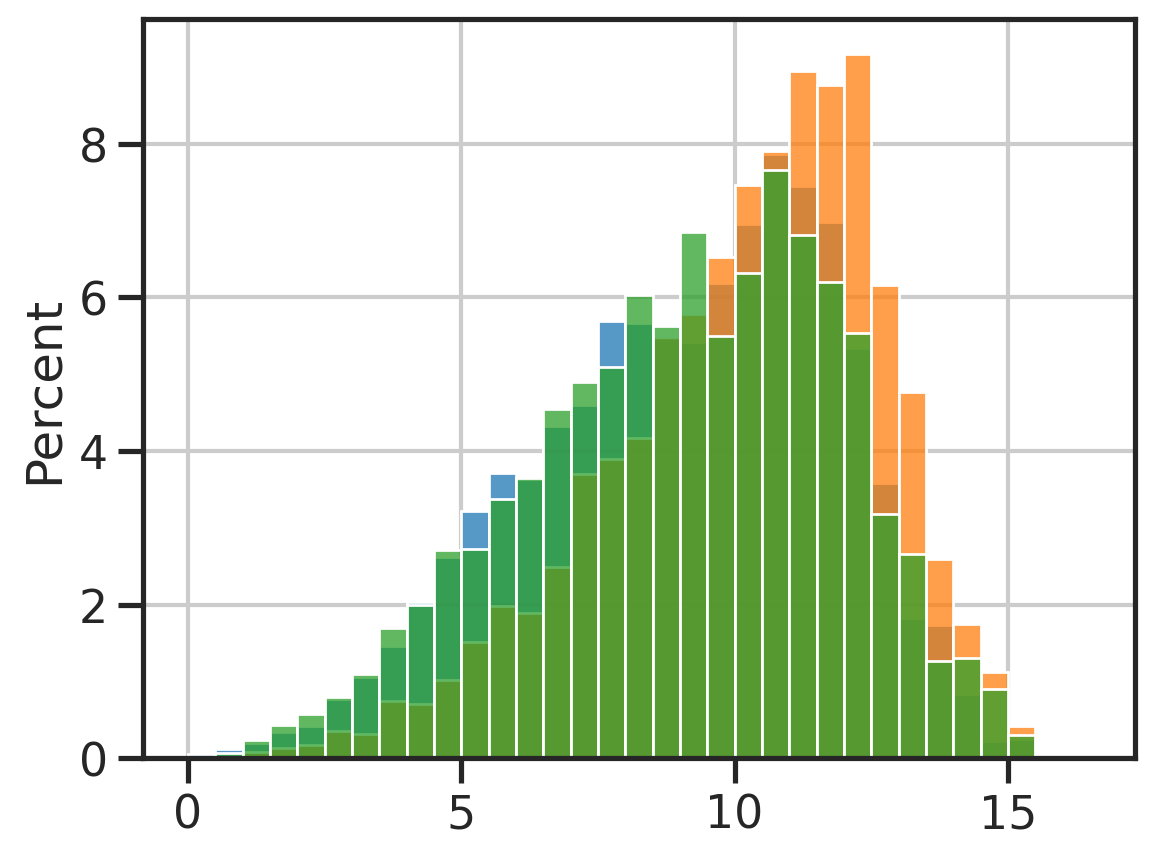

In [62]:
sns.histplot(np.min(dists_nr28, axis=0), stat='percent', bins=np.arange(0,17,0.5))
sns.histplot(np.min(dists_dr28, axis=0), stat='percent', bins=np.arange(0,17,0.5))
sns.histplot(np.min(dists_dl28, axis=0), stat='percent', bins=np.arange(0,17,0.5))

# sns.histplot(np.min(dists_nr38, axis=0), stat='percent', bins=np.arange(0,17,0.5))
# sns.histplot(np.min(dists_dr38, axis=0), stat='percent', bins=np.arange(0,17,0.5))

<Axes: ylabel='Percent'>

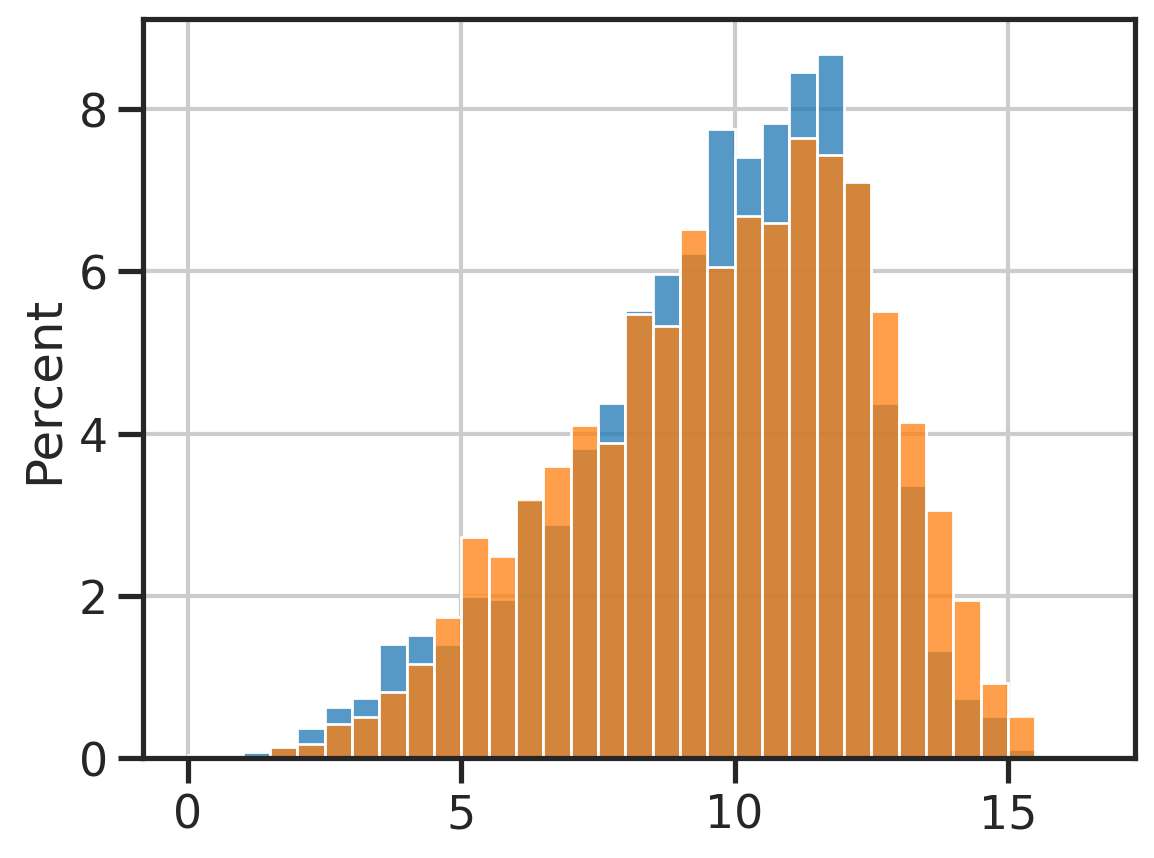

In [63]:
sns.histplot(np.min(dists_nr38, axis=0), stat='percent', bins=np.arange(0,17,0.5))
sns.histplot(np.min(dists_dr38, axis=0), stat='percent', bins=np.arange(0,17,0.5))